In [1]:
import os
import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

import antea.reco.reco_functions   as rf
import antea.reco.mctrue_functions as mcf

### Extracting info from PETALO data

In [4]:
path_to_file = '/Users/carmenromoluque/Desktop/'
#filename     = path_to_file + 'full_body_iradius380mm_z200cm_depth3cm_pitch7mm.100.pet.h5'
filename     = path_to_file + 'full_body_iradius380mm_z200cm_depth4cm_pitch7mm.022.pet.h5'

In [5]:
sns_response = pd.read_hdf(filename, 'MC/waveforms'       )
tof_response = pd.read_hdf(filename, 'MC/tof_waveforms'   )
particles    = pd.read_hdf(filename, 'MC/particles'       )
hits         = pd.read_hdf(filename, 'MC/hits'            )
sens_pos     = pd.read_hdf(filename, 'MC/sensor_positions')

In [6]:
DataSiPM     = sens_pos.rename(columns={"sensor_id": "SensorID","x": "X", "y": "Y", "z": "Z"})
DataSiPM_idx = DataSiPM.set_index('SensorID')

In [7]:
## Important functions
def greater_or_equal(f1: float, f2: float, allowed_error: float = 1.e-6) -> bool:
    return f1 >= f2 - allowed_error

def lower_or_equal(f1: float, f2: float, allowed_error: float = 1.e-6) -> bool:
    return f1 <= f2 + allowed_error

def lower(f1: float, f2: float, allowed_error: float = 1.e-6) -> bool:
    return f1 < f2 + allowed_error

## Only photelectric evts

In [105]:
phot_evts_dict = {}
events         = particles.event_id.unique()

for evt in events[200:400]:
    evt_parts = particles[particles.event_id == evt]
    evt_hits  = hits     [hits     .event_id == evt]
    
    sel_volume   = (evt_parts.initial_volume == 'ACTIVE') & (evt_parts.final_volume == 'ACTIVE')
    sel_name     =  evt_parts.name == 'e-'
    sel_vol_name = evt_parts[sel_volume & sel_name]
    ids          = sel_vol_name.particle_id.values

    sel_hits   = evt_hits[evt_hits.particle_id.isin(ids)]
    energies   = sel_hits.groupby(['particle_id'])[['energy']].sum()
    energies   = energies.reset_index()

    ## Photoelectric selection
    energy_sel = energies[greater_or_equal(energies.energy, 0.476443, allowed_error=1.e-6)]
        
    sel_vol_name_e  = sel_vol_name[sel_vol_name.particle_id.isin(energy_sel.particle_id)]
    primaries       = evt_parts[evt_parts.primary == True]
    sel_all         = sel_vol_name_e[sel_vol_name_e.mother_id.isin(primaries.particle_id.values)]
    if len(sel_all)==0:
        continue
    if len(sel_all)==2:
        print(evt)
    
    #### Once the event has passed the selection, let's calculate the true position(s)
    #### to look for the touched SiPMs
    ids      = sel_all.particle_id.values
    sel_hits = evt_hits[evt_hits.particle_id.isin(ids)]
    
    sel_hits = sel_hits.groupby(['particle_id'])
    true_pos = []
    for _, df in sel_hits:
        hit_positions = np.array([df.x.values, df.y.values, df.z.values]).transpose()
        true_pos.append(np.average(hit_positions, axis=0, weights=df.energy))
        
    phot_evts_dict[evt] = true_pos

660295
660337


In [10]:
pd.DataFrame.from_dict(phot_evts_dict, orient='index').head()

,0,1
660003,"[334.5123, -251.39444, -46.343693]",None
660009,"[-167.76497, 363.98648, -380.8227]",None
660020,"[97.07951, -375.24963, -62.387684]",None
660021,"[-54.61403, 406.99597, -88.78594]",None
660030,"[96.98378, -393.89737, 45.932926]",None


In [106]:
phot_evts_dict

{660205: [array([-224.27185,  339.04614, -210.8869 ], dtype=float32)],
 660209: [array([ 184.04861, -339.29807, -134.66408], dtype=float32)],
 660211: [array([ 80.88332, 396.418  , -61.10155], dtype=float32)],
 660217: [array([-376.0045  ,  -64.677605,  480.36276 ], dtype=float32)],
 660224: [array([-223.42616,  316.4102 ,  365.34024], dtype=float32)],
 660234: [array([126.58126, 377.5234 ,  33.10734], dtype=float32)],
 660239: [array([-408.4704  ,  -90.058205, -283.25043 ], dtype=float32)],
 660245: [array([332.66306 , 214.88354 ,  27.665129], dtype=float32)],
 660247: [array([-319.67044,  209.07718, -796.9724 ], dtype=float32)],
 660249: [array([385.19226  , 156.64633  ,  -7.4962873], dtype=float32)],
 660251: [array([ 381.00052 ,  -57.093487, -191.5672  ], dtype=float32)],
 660252: [array([-283.96832, -266.536  , -870.3396 ], dtype=float32)],
 660254: [array([311.8615  , 269.46005 ,  -5.464234], dtype=float32)],
 660259: [array([ 157.91217, -349.30536,  296.0043 ], dtype=float32)],


## Plot the SiPMs

In [21]:
def from_cartesian_to_cyl(pos):
    cyl_pos = np.array([np.sqrt(pos[:,0]**2+pos[:,1]**2), np.arctan2(pos[:,1], pos[:,0]), pos[:,2]]).transpose()
    return cyl_pos

def find_SiPMs_over_threshold(df, threshold):
    tot_charges_df = df.groupby(['event_id','sensor_id'])[['charge']].sum()
    return tot_charges_df[tot_charges_df.charge > threshold].reset_index()

def find_closest_sipm(point, sipms):
    sns_positions = np.array([sipms.X.values, sipms.Y.values, sipms.Z.values]).transpose()
    subtr         = [np.subtract(point, pos) for pos in sns_positions]
    distances     = [np.linalg.norm(d) for d in subtr]
    min_dist      = np.min(distances)
    min_sipm      = np.isclose(distances, min_dist)
    closest_sipm  = sipms[min_sipm]
    return closest_sipm.iloc[0]

def assign_sipms_to_gammas(sns_response, true_pos, DataSiPM_idx):
    if 'SensorID' in DataSiPM_idx.columns:
        DataSiPM_idx = DataSiPM_idx.set_index('SensorID')
    sipms           = DataSiPM_idx.loc[sns_response.sensor_id]
    sns_ids         = sipms.index.astype('int64').values
    sns_closest_pos = [np.array([find_closest_sipm(pos, sipms).X,
                                 find_closest_sipm(pos, sipms).Y,
                                 find_closest_sipm(pos, sipms).Z]) for pos in true_pos]
    q1,   q2   = [], []
    pos1, pos2 = [], []
    id1, id2   = [], []

    sns_positions = np.array([sipms.X.values, sipms.Y.values, sipms.Z.values]).transpose()
    sns_charges   = sns_response.charge
    closest_pos   = sns_closest_pos[0] ## Look at the first one, which always exists.

    for sns_id, sns_pos, charge in zip(sns_ids, sns_positions, sns_charges):
        scalar_prod = sns_pos.dot(closest_pos)
        if scalar_prod > 0.:
            q1  .append(charge)
            pos1.append(sns_pos)
            id1 .append(sns_id)
        elif len(sns_closest_pos) == 2:
            q2  .append(charge)
            pos2.append(sns_pos)
            id2 .append(sns_id)

    return id1, id2, pos1, pos2, q1, q2

### For the photoelectric events we extract the charge and the sensors id by introducing the event number previously stored

In [109]:
sel_df    = find_SiPMs_over_threshold(sns_response, threshold=2)
for evt, true_pos in phot_evts_dict.items():
    if evt == 660337:
        waveforms = sel_df[sel_df.event_id == evt]
        id1, id2, pos1, pos2, q1, q2 = assign_sipms_to_gammas(waveforms, true_pos, DataSiPM_idx)
        print(evt, len(id1), len(id2))

660337 64 180


Text(0, 0.5, 'SiPMs z')

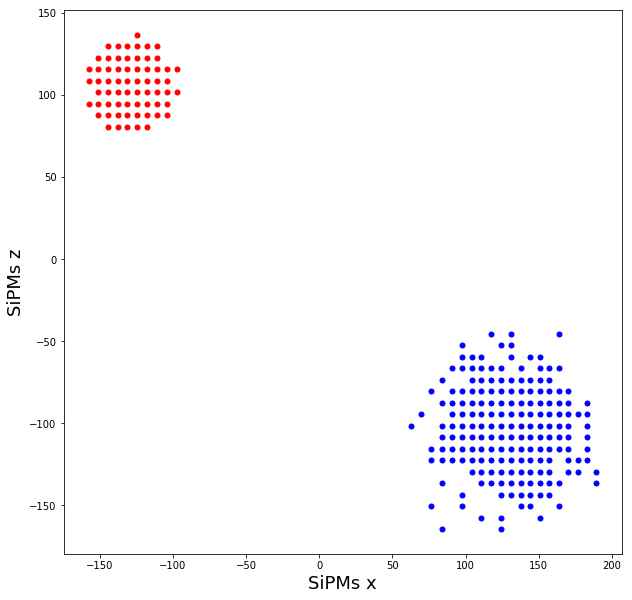

In [110]:
pos1_x   = np.array([el[0] for el in pos1])
pos1_y   = np.array([el[1] for el in pos1])
pos1_z   = np.array([el[2] for el in pos1])
pos1_cyl = from_cartesian_to_cyl(np.array(pos1)).transpose()
pos1_phi = pos1_cyl[1]

pos2_x   = np.array([el[0] for el in pos2])
pos2_y   = np.array([el[1] for el in pos2])
pos2_z   = np.array([el[2] for el in pos2])
pos2_cyl = from_cartesian_to_cyl(np.array(pos2)).transpose()
pos2_phi = pos2_cyl[1]

pos_x   = np.concatenate((pos1_x,   pos2_x))
pos_y   = np.concatenate((pos1_y,   pos2_y))
pos_z   = np.concatenate((pos1_z,   pos2_z))
pos_phi = np.concatenate((pos1_phi, pos2_phi))
weights = np.concatenate((q1,       q2))

plt.figure(figsize=(10,10))
plt.plot(pos1_x, pos1_z, '.', c='r', markersize=10)
plt.plot(pos2_x, pos2_z, '.', c='b', markersize=10)
plt.xlabel('SiPMs x', size=18)
plt.ylabel('SiPMs z', size=18)
#plt.ylim(-1000,1000)

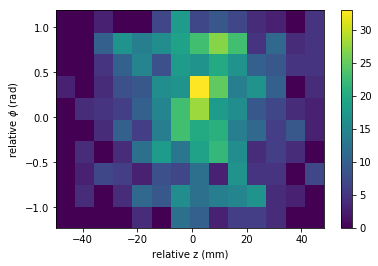

In [46]:
## Relative distance
evt = 660137
true_pos1     = np.array(phot_evts_dict[evt])[0]
true_pos2     = np.array(phot_evts_dict[evt])[1]
rel_dist1     = np.array(true_pos1 - pos1)
rel_dist1_cyl = from_cartesian_to_cyl(rel_dist1).transpose()
rel_dist2     = np.array(true_pos2 - pos2)
rel_dist2_cyl = from_cartesian_to_cyl(rel_dist2).transpose()

h_r, xedges_r, yedges_r, img_r = plt.hist2d(rel_dist1_cyl[2], rel_dist1_cyl[1], bins=(14, 10), weights=q1)
plt.xlabel('relative z (mm)')
plt.ylabel('relative $\phi$ (rad)')
plt.colorbar()
plt.show()

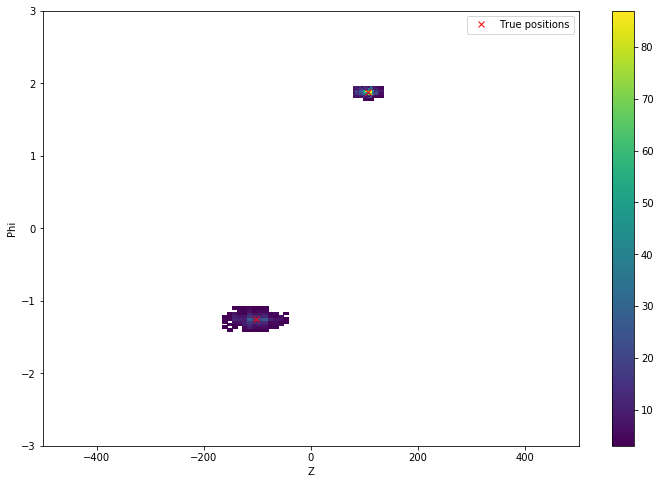

In [111]:
evt = 660337
true_pos_cyl        = from_cartesian_to_cyl(np.array(phot_evts_dict[evt]))
true_pos_cyl_transp = true_pos_cyl.transpose()

fig = plt.figure(figsize=(12,8))
h_r, xedges_r, yedges_r, img_r = plt.hist2d(pos_z, pos_phi, weights=weights, bins=(32, 90), cmin=1)
h_r, xedges_r, yedges_r, img_r = plt.hist2d(pos1_z, pos1_phi, weights=q1, bins=(32, 90), cmin=1)
plt.plot(true_pos_cyl_transp[2], true_pos_cyl_transp[1], 'rx', label='True positions')
plt.xlabel('Z')
plt.ylabel('Phi')
plt.xlim(-500, 500)
plt.ylim(-3, 3)
plt.colorbar()
plt.legend()
plt.show()

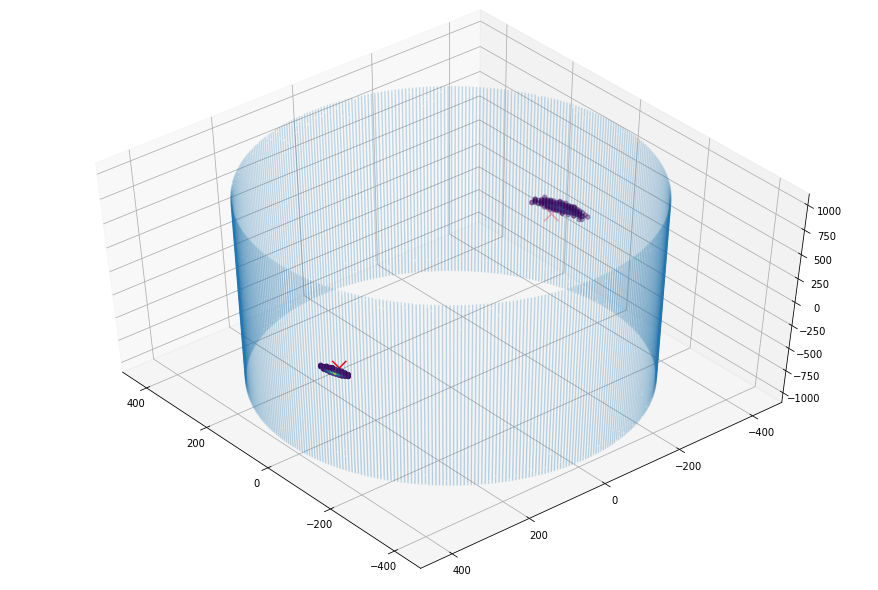

In [116]:
true_pos_x = np.array(phot_evts_dict[evt]).transpose()[0]
true_pos_y = np.array(phot_evts_dict[evt]).transpose()[1]
true_pos_z = np.array(phot_evts_dict[evt]).transpose()[2]

fig = plt.figure(figsize=(12,8))
ax  = Axes3D(fig)
ax.scatter(DataSiPM.X.values, DataSiPM.Y.values, DataSiPM.Z.values, marker='o', s=0.5, alpha=0.1)
ax.scatter(pos_x, pos_y, pos_z, c=weights, marker='o', s=20)
ax.scatter(true_pos_x, true_pos_y, true_pos_z, marker='x', c='r', s=200)
ax.view_init(azim=140, elev=50)

### Same event in 2D

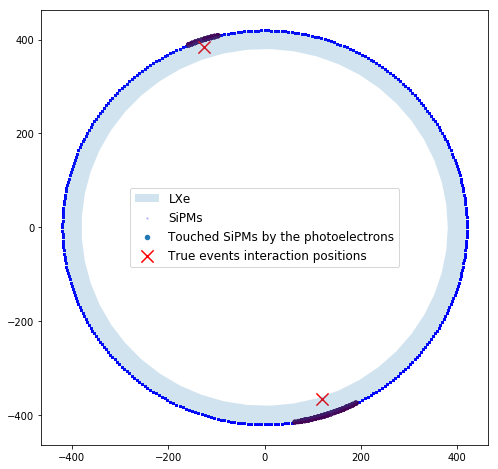

In [147]:
fig = plt.figure(figsize=(8,8))

## Define the ring
n, radii = 50, [r_int, r_ext]
theta = np.linspace(0, 2*np.pi, n, endpoint=True)
xs = np.outer(radii, np.cos(theta))
ys = np.outer(radii, np.sin(theta))

# in order to have a closed area, the circles
# should be traversed in opposite directions
xs[1,:] = xs[1,::-1]
ys[1,:] = ys[1,::-1]

ax = fig.gca()
ax.fill(np.ravel(xs), np.ravel(ys), alpha=0.2, label='LXe')

plt.scatter(DataSiPM.X.values, DataSiPM.Y.values, marker='o', s=2, alpha=0.2, label='SiPMs', c='b')
plt.scatter(pos_x, pos_y, c=weights, marker='o', s=20, label='Touched SiPMs by the photoelectrons')
plt.scatter(true_pos_x, true_pos_y, marker='x', c='r', s=150, label='True events interaction positions')
plt.legend(fontsize=12)
plt.show()

### Final images I want to store and pass to the network

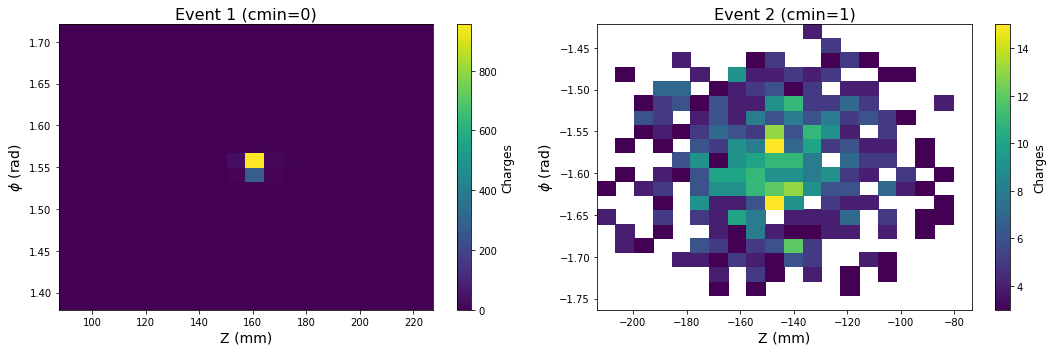

In [27]:
barycenter_touched_sns1_cyl = np.average(pos1_cyl, axis=1, weights=q1)
barycenter_touched_sns2_cyl = np.average(pos2_cyl, axis=1, weights=q2)
dist_between_sns_phi = 0.01707387
dist_between_sns_z   = 7 #mm (pitch)
range_phi1 = (barycenter_touched_sns1_cyl[1] - 10*dist_between_sns_phi, 
                  barycenter_touched_sns1_cyl[1] + 10*dist_between_sns_phi)
range_z1   = (barycenter_touched_sns1_cyl[2] - 10*dist_between_sns_z, 
                  barycenter_touched_sns1_cyl[2] + 10*dist_between_sns_z)
range_phi2 = (barycenter_touched_sns2_cyl[1] - 10*dist_between_sns_phi, 
                  barycenter_touched_sns2_cyl[1] + 10*dist_between_sns_phi)
range_z2   = (barycenter_touched_sns2_cyl[2] - 10*dist_between_sns_z, 
                  barycenter_touched_sns2_cyl[2] + 10*dist_between_sns_z)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
h1 = ax1.hist2d(pos1_cyl[2], pos1_cyl[1], bins=(20, 20), 
                range=(range_z1, range_phi1), weights=q1)
h2 = ax2.hist2d(pos2_cyl[2], pos2_cyl[1], bins=(20, 20), 
                range=(range_z2, range_phi2), weights=q2, cmin=1)
ax1.set_xlabel('Z (mm)',          size=14)
ax1.set_ylabel('$\phi$ (rad)',    size=14)
ax1.set_title('Event 1 (cmin=0)', size=16)
ax2.set_xlabel('Z (mm)',          size=14)
ax2.set_ylabel('$\phi$ (rad)',    size=14)
ax2.set_title('Event 2 (cmin=1)', size=16)
#plt.colorbar().set_label("Number of events")
cbar1 = plt.colorbar(h1[3], ax=ax1)
cbar1.set_label('Charges', size=12)
cbar2 = plt.colorbar(h2[3], ax=ax2)
cbar2.set_label('Charges', size=12)
plt.tight_layout()

In [28]:
def twoevents_matrix_z_phi(evt, pos1_cyl, pos2_cyl, q1, q2, 
                           range_z1, range_z2, range_phi1, range_phi2):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
    fig.suptitle(f'Evt {evt}', size=16)
    h1 = ax1.hist2d(pos1_cyl[2], pos1_cyl[1], bins=(20, 20), 
                    range=(range_z1, range_phi1), weights=q1)
    h2 = ax2.hist2d(pos2_cyl[2], pos2_cyl[1], bins=(20, 20), 
                    range=(range_z2, range_phi2), weights=q2)
    ax1.set_xlabel('Z (mm)',       size=14)
    ax1.set_ylabel('$\phi$ (rad)', size=14)
    ax1.set_title(f'Event 1, {len(q1)} touched sipms', size=15)
    ax2.set_xlabel('Z (mm)',       size=14)
    ax2.set_ylabel('$\phi$ (rad)', size=14)
    ax2.set_title(f'Event 2, {len(q2)} touched sipms', size=15)

    cbar1 = plt.colorbar(h1[3], ax=ax1)
    cbar1.set_label('Charges', size=12)
    cbar2 = plt.colorbar(h2[3], ax=ax2)
    cbar2.set_label('Charges', size=12)
    plt.tight_layout()
    return h1, h2

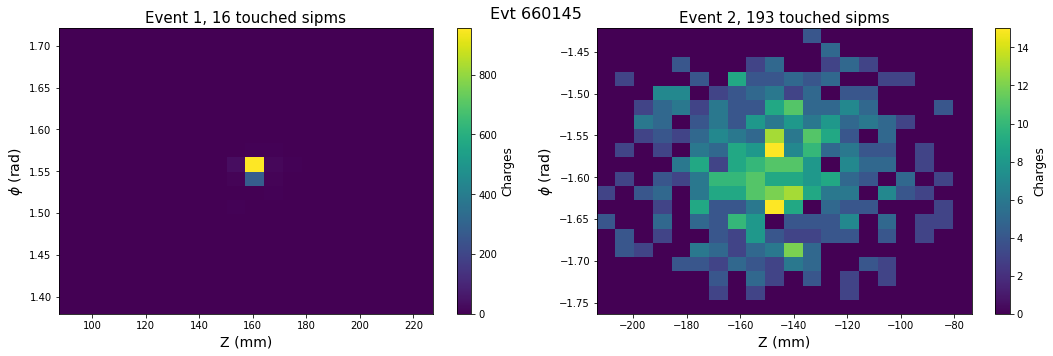

In [29]:
h1, h2 = twoevents_matrix_z_phi(evt, pos1_cyl, pos2_cyl, q1, q2, 
                           range_z1, range_z2, range_phi1, range_phi2)

In [30]:
def single_event_matrix_z_phi(evt, pos1_cyl, q1, range_z1, range_phi1):
    fig = plt.figure(figsize=(7,5))
    h1 = plt.hist2d(pos1_cyl[2], pos1_cyl[1], bins=(20, 20), 
                    range=(range_z1, range_phi1), weights=q1)
    plt.xlabel('Z (mm)',       size=14)
    plt.ylabel('$\phi$ (rad)', size=14)
    plt.title(f'Single evt {evt}, {len(q1)} touched sipms',  size=15)
    plt.colorbar().set_label('Charges', size=12)
    return h1

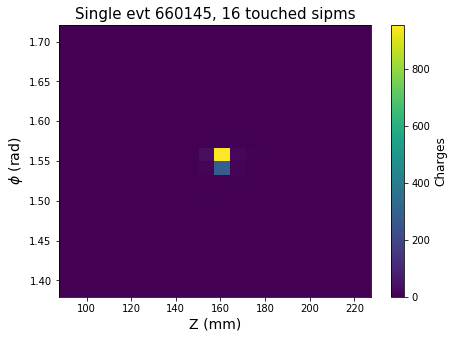

In [31]:
h1 = single_event_matrix_z_phi(evt, pos1_cyl, q1, range_z1, range_phi1)

## Loop over all the phot events stored in the dict

In [82]:
def needed_info_to_plot(pos, q):
    pos_cyl = from_cartesian_to_cyl(np.array(pos)).transpose()
    barycenter_touched_sns_cyl = np.average(pos_cyl, axis=1, weights=q)
    dist_between_sns_phi = 0.01707387
    dist_between_sns_z   = 7. #mm (pitch)
    range_phi = (barycenter_touched_sns_cyl[1] - 10*dist_between_sns_phi, 
                 barycenter_touched_sns_cyl[1] + 10*dist_between_sns_phi)
    range_z   = (barycenter_touched_sns_cyl[2] - 10*dist_between_sns_z, 
                 barycenter_touched_sns_cyl[2] + 10*dist_between_sns_z)
    return pos_cyl, range_z, range_phi

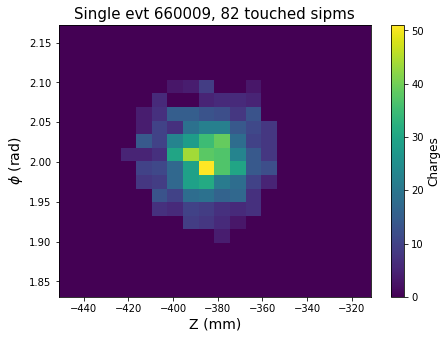

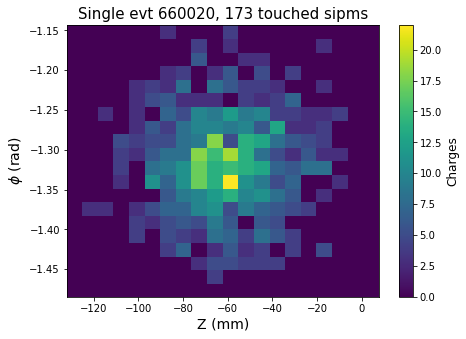

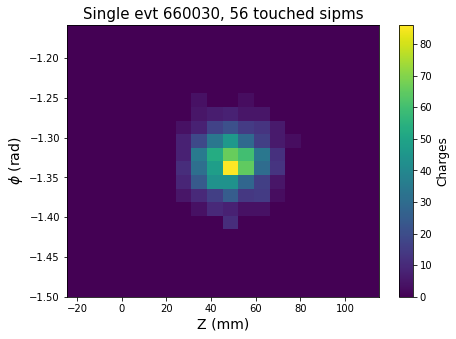

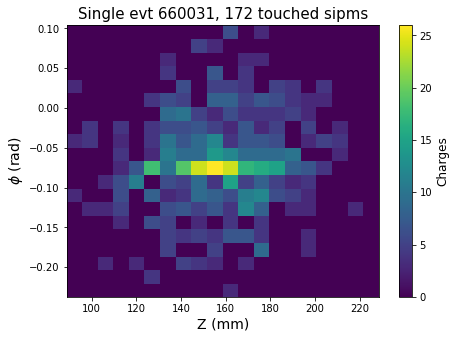

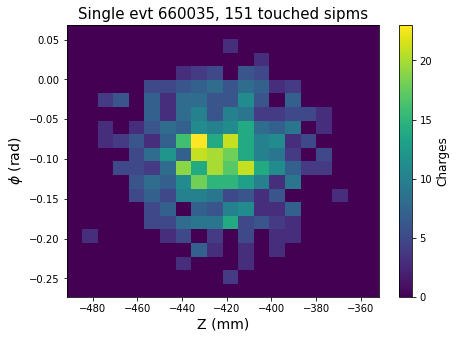

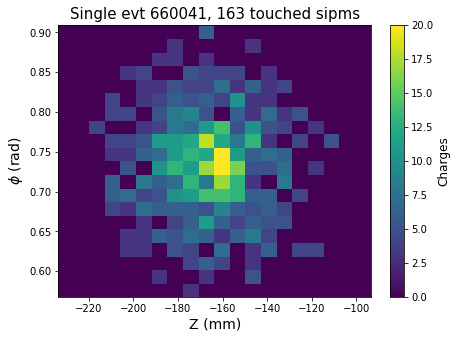

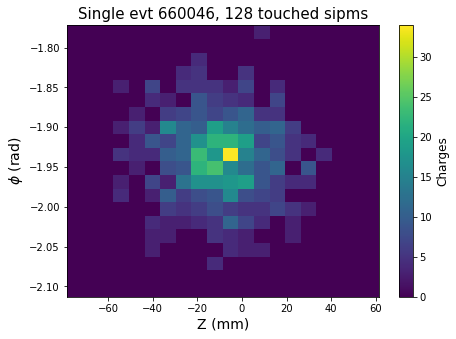

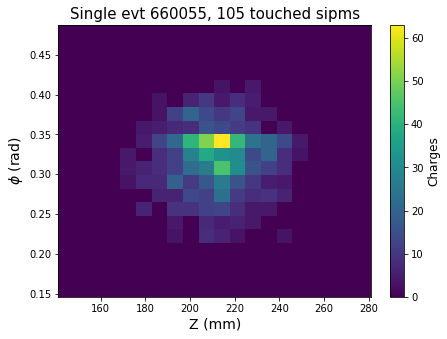

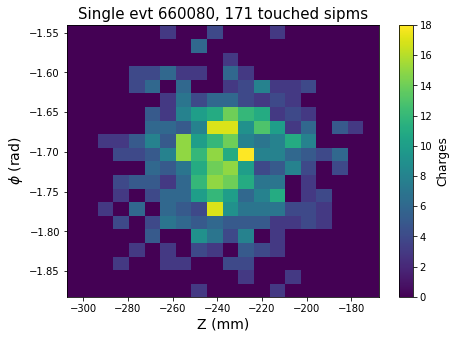

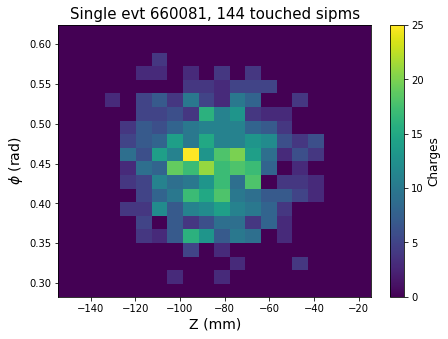

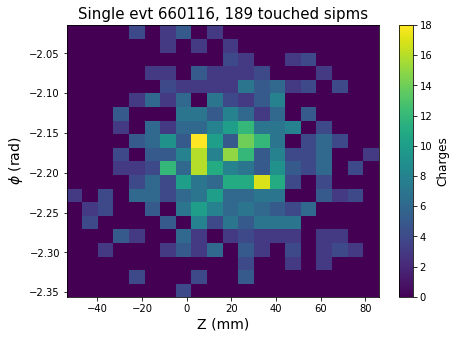

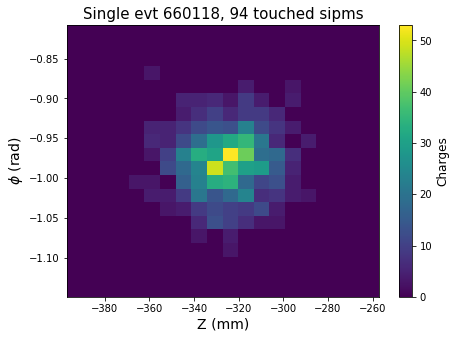

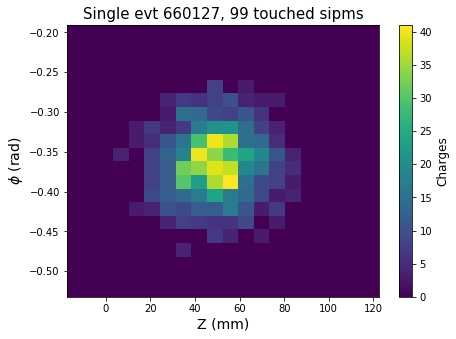

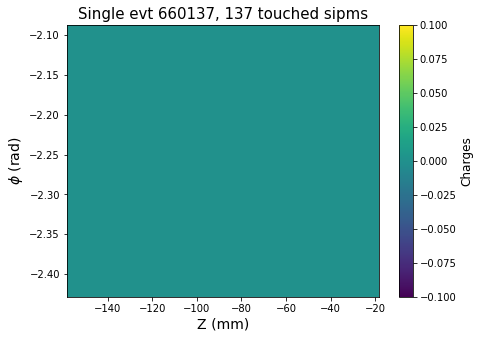

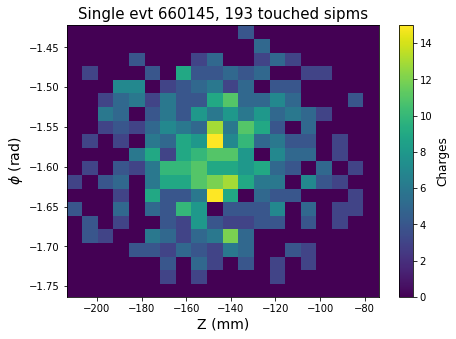

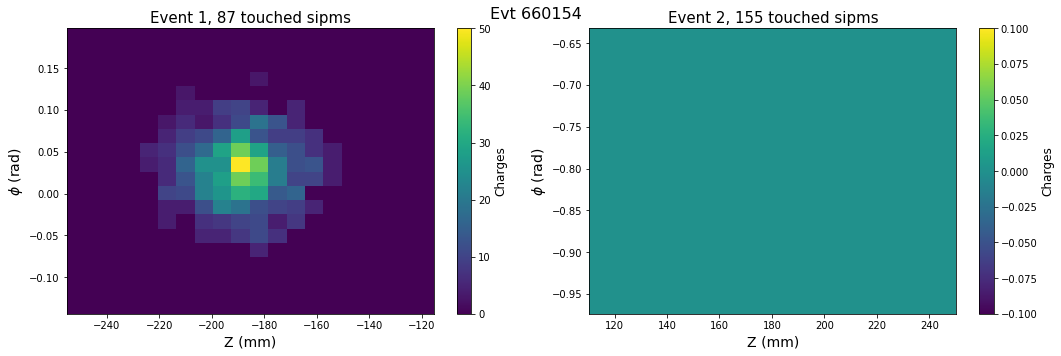

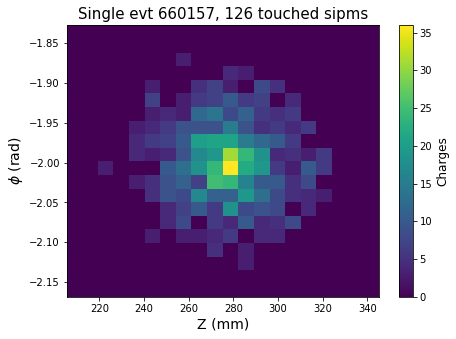

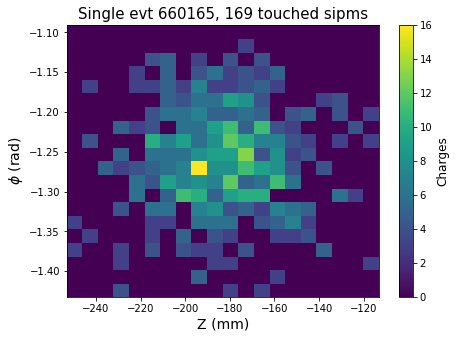

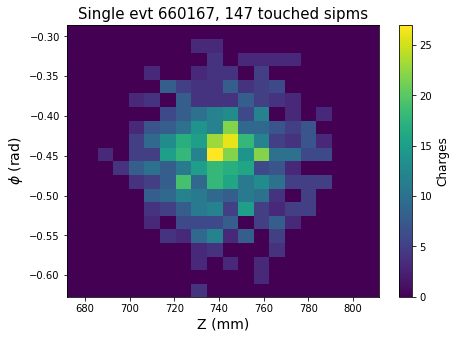

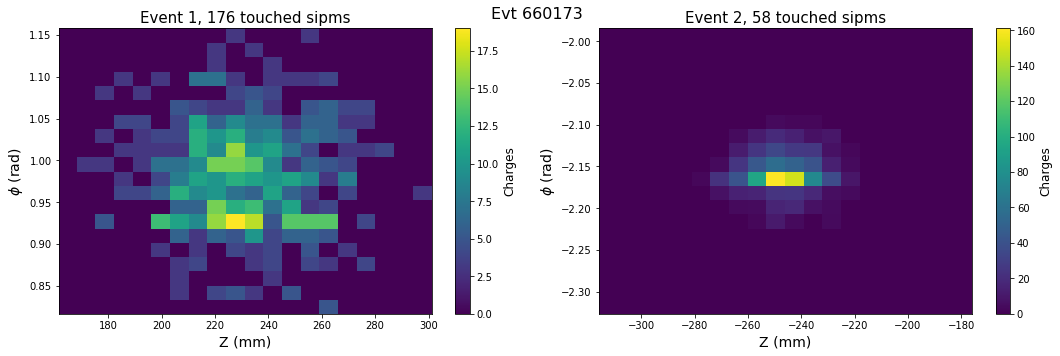

In [104]:
sel_df          = find_SiPMs_over_threshold(sns_response, threshold=2)
images          = []
min_touched_sns = 50
for ev_num, truepos in phot_evts_dict.items():
    if ev_num == 660176:
        break
    waveforms = sel_df[sel_df.event_id == ev_num]
    id1, id2, pos1, pos2, q1, q2 = assign_sipms_to_gammas(waveforms, truepos, DataSiPM_idx)
    if len(id1)>min_touched_sns and len(id2)>min_touched_sns:
        pos1_cyl, range_z1, range_phi1 = needed_info_to_plot(pos1, q1)
        pos2_cyl, range_z2, range_phi2 = needed_info_to_plot(pos2, q2)
        h1, h2 = twoevents_matrix_z_phi(ev_num, pos1_cyl, pos2_cyl, q1, q2, 
                           range_z1, range_z2, range_phi1, range_phi2)
        if len(np.nonzero(h1[0].flatten())[0])>min_touched_sns:
            images.append(h1)
        if len(np.nonzero(h2[0].flatten())[0])>min_touched_sns:
            images.append(h2)
    else:
        if len(pos1)>min_touched_sns:
            pos1_cyl, range_z1, range_phi1 = needed_info_to_plot(pos1, q1)
        elif len(id2)>min_touched_sns:
            pos1_cyl, range_z1, range_phi1 = needed_info_to_plot(pos2, q2)
            q1 = q2
        else:
            continue
        h1 = single_event_matrix_z_phi(ev_num, pos1_cyl, q1, range_z1, range_phi1)
        if len(np.nonzero(h1[0].flatten())[0])>min_touched_sns:
            images.append(h1)

In [107]:
len(images)

20

## Analizing npz file:

In [55]:
filepath = '/Users/carmenromoluque/Desktop/'

list_dicts = []
for filename in os.listdir(filepath):
    if filename.endswith('2.npz'):
        my_file = filepath+filename
        d   = np.load(my_file, allow_pickle=True)
        phot_images = d['phot_images']
        print(phot_images.shape)

(8, 1, 20, 20)


In [60]:
h2[0].shape

(20, 20)

## Compton:

In [89]:
def select_compton(evt_parts, evt_hits):
    sel_volume   = (evt_parts.initial_volume == 'ACTIVE') & (evt_parts.final_volume == 'ACTIVE')
    sel_name     =  evt_parts.name == 'e-'
    sel_vol_name = evt_parts[sel_volume & sel_name]
    ids          = sel_vol_name.particle_id.values

    sel_hits   = mcf.find_hits_of_given_particles(ids, evt_hits)
    energies   = sel_hits.groupby(['particle_id'])[['energy']].sum()
    energies   = energies.reset_index()
    ## Compton selection
    energy_sel = energies[greater_or_equal(energies.energy, 0.2,     allowed_error=1.e-6) & 
                          lower           (energies.energy, 0.45, allowed_error=1.e-6)]


    sel_vol_name_e  = sel_vol_name[sel_vol_name.particle_id.isin(energy_sel.particle_id)]

    primaries = evt_parts[evt_parts.primary == True]
    sel_all   = sel_vol_name_e[sel_vol_name_e.mother_id.isin(primaries.particle_id.values)]
    if len(sel_all) == 0:
        return (False, [])

    ### Once the event has passed the selection, let's calculate the true position(s)
    ids      = sel_all.particle_id.values
    sel_hits = mcf.find_hits_of_given_particles(ids, evt_hits)

    sel_hits = sel_hits.groupby(['particle_id'])
    true_pos = []
    for _, df in sel_hits:
        hit_positions = np.array([df.x.values, df.y.values, df.z.values]).transpose()
        true_pos.append(np.average(hit_positions, axis=0, weights=df.energy))

    ### Reject events where the two gammas have interacted in the same hemisphere.
    #if (len(true_pos) == 1) & (evt_hits.energy.sum() > 0.511):
    #    return (False, [])

    return (True, true_pos)

In [90]:
compton_evts_dict = {}
for evt in events[:100]:
    ### Select compton events only
    evt_parts = particles[particles.event_id == evt]
    evt_hits  = hits     [hits     .event_id == evt]
    select, true_pos = select_compton(evt_parts, evt_hits)
    if select:
        compton_evts_dict[evt] = true_pos

In [91]:
compton_evts_dict

{660000: [array([410.22192, -76.45328, 582.347  ], dtype=float32)],
 660001: [array([ 354.67612, -140.0893 ,  122.30025], dtype=float32),
  array([-360.62164,  132.12646, -145.41478], dtype=float32)],
 660002: [array([380.41446 , -25.523655, -17.15004 ], dtype=float32),
  array([-405.40735 ,   37.327972,   53.225544], dtype=float32)],
 660004: [array([374.6235   ,  93.945015 ,   1.7851702], dtype=float32),
  array([-382.68204 , -108.39688 ,    8.696658], dtype=float32)],
 660005: [array([ 127.42044, -378.00528,  176.05359], dtype=float32)],
 660006: [array([-381.46945 ,  131.54404 ,   27.461254], dtype=float32),
  array([-400.37552 ,  106.94183 ,    4.174459], dtype=float32),
  array([ 371.10397 , -127.99807 ,  -26.791979], dtype=float32),
  array([ 373.25323 , -126.558754,  -19.814981], dtype=float32)],
 660007: [array([107.495514, 365.28012 , 501.5164  ], dtype=float32)],
 660008: [array([-267.4227 ,  311.9072 ,   74.14626], dtype=float32)],
 660009: [array([ 181.11357, -371.1337 ,  

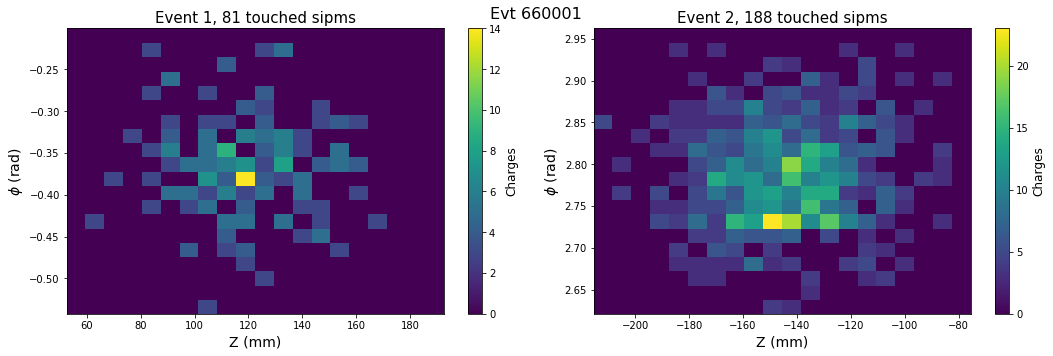

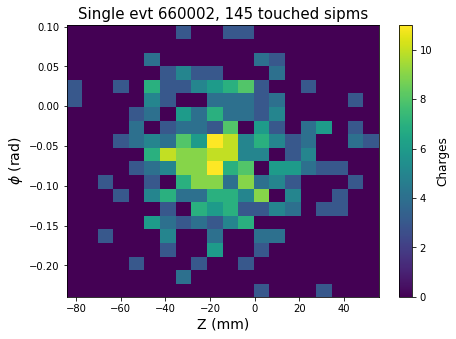

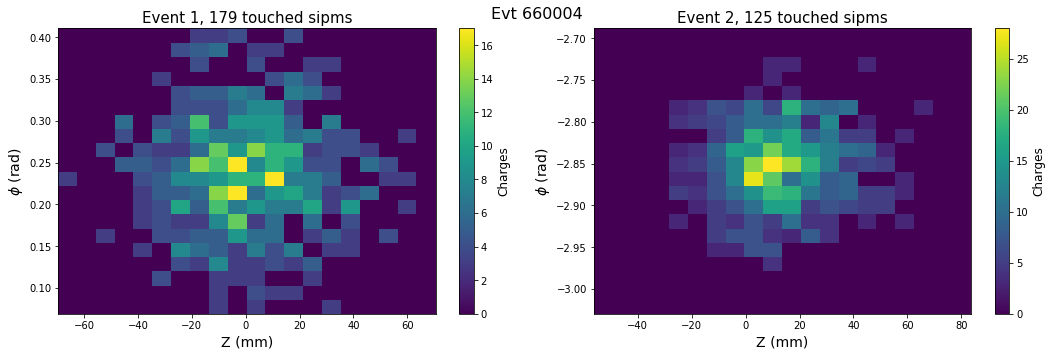

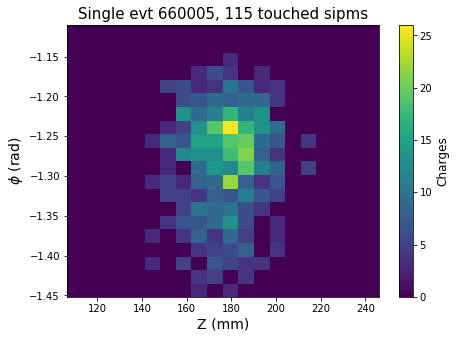

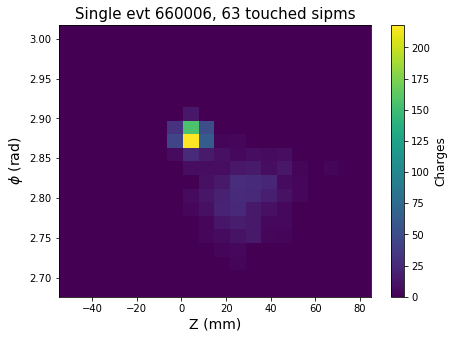

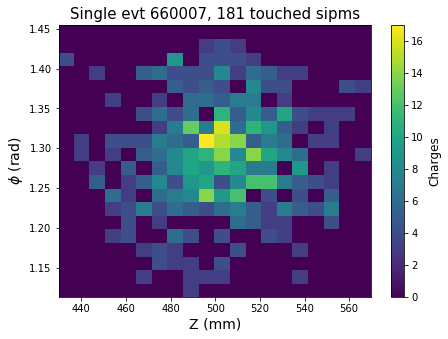

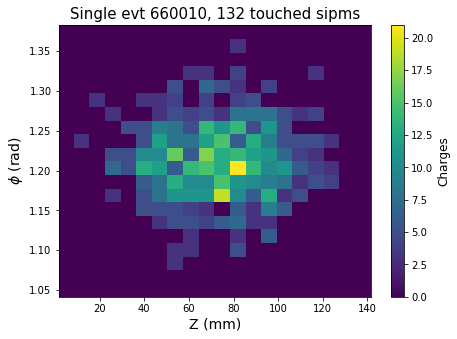

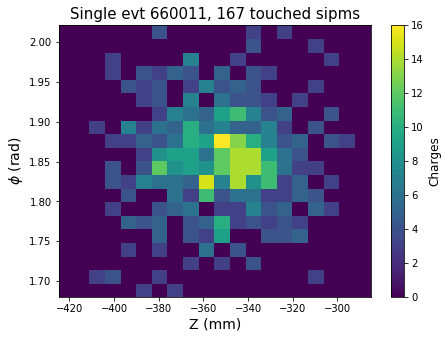

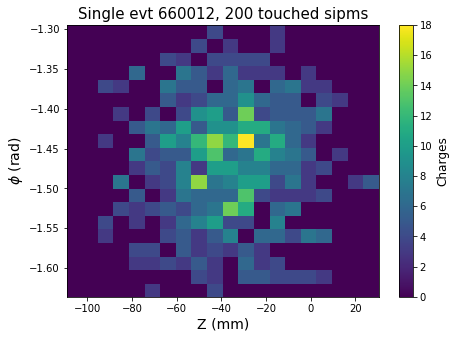

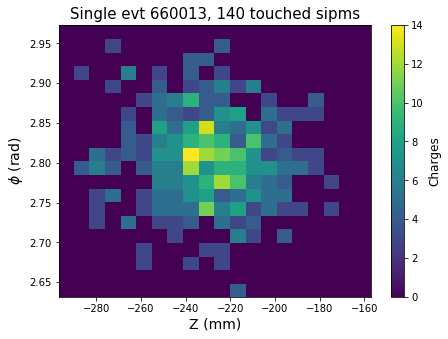

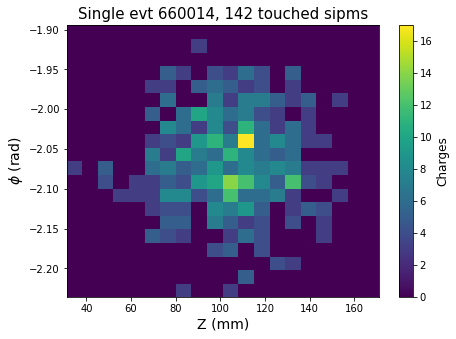

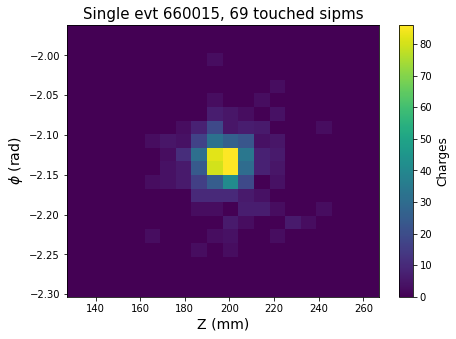

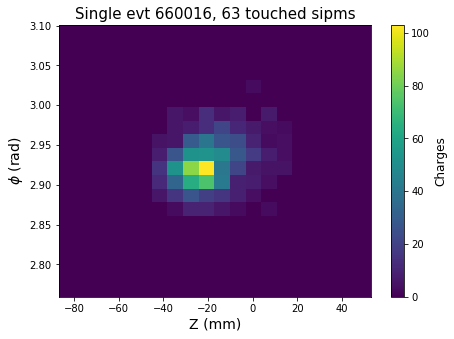

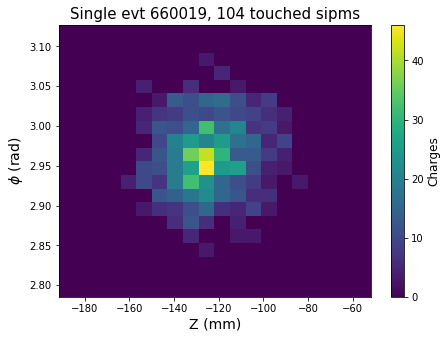

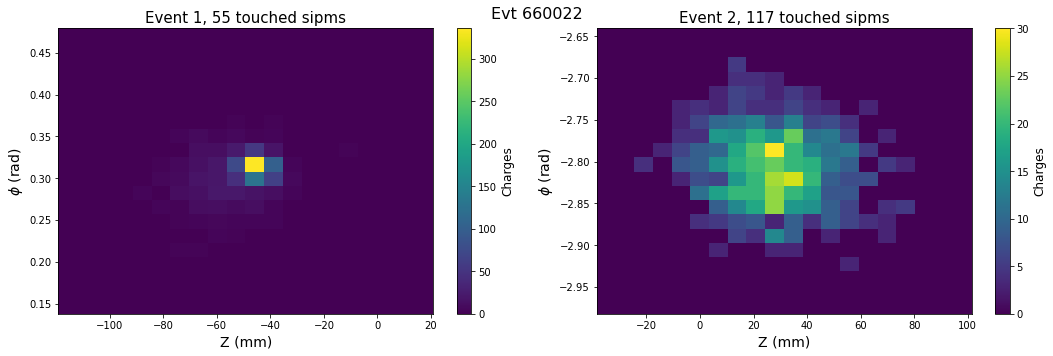

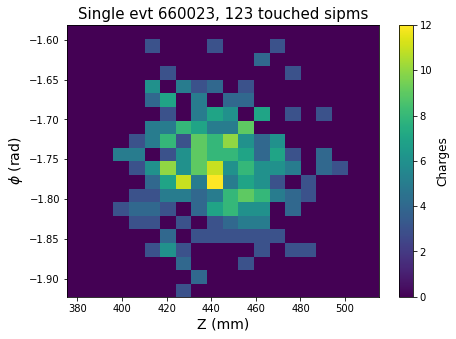

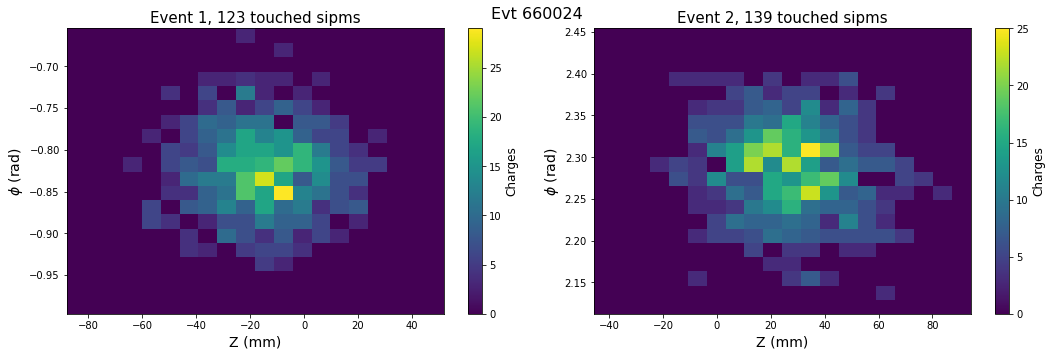

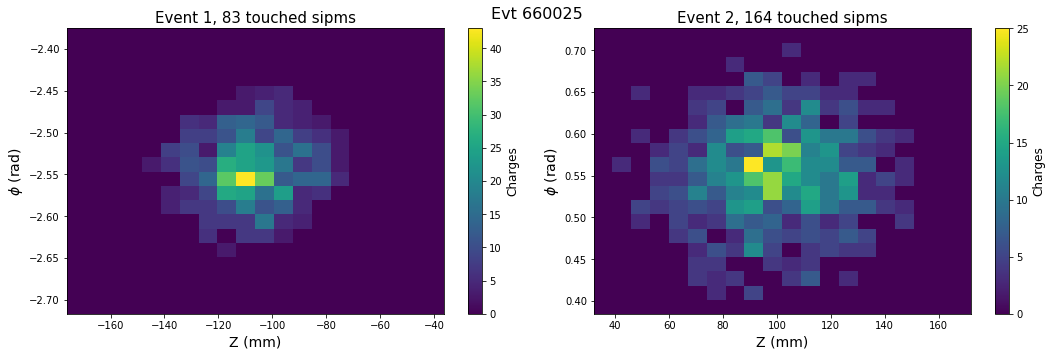

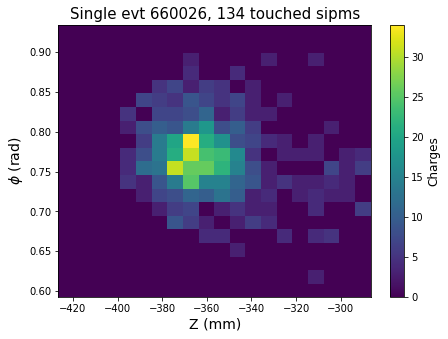

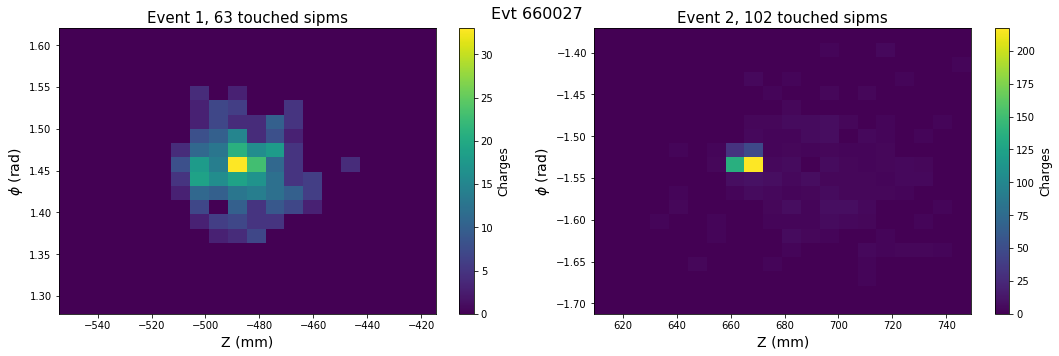

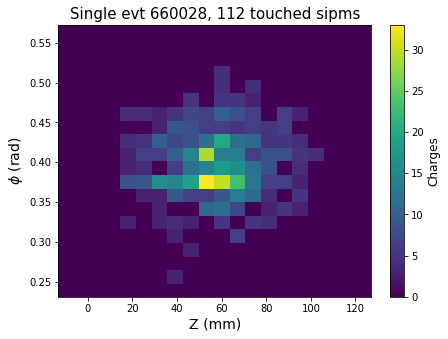

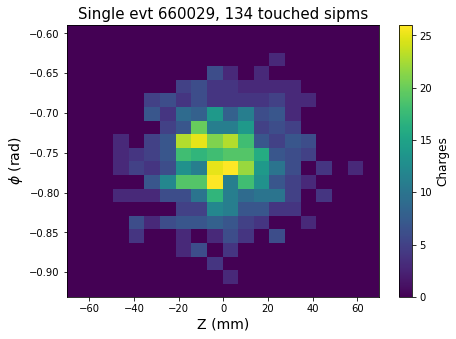

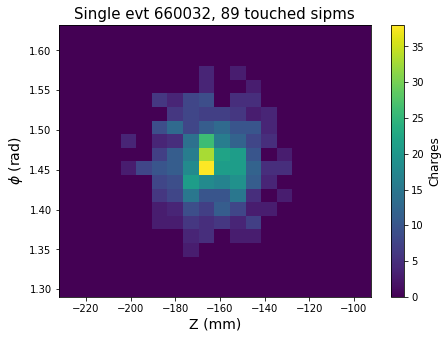

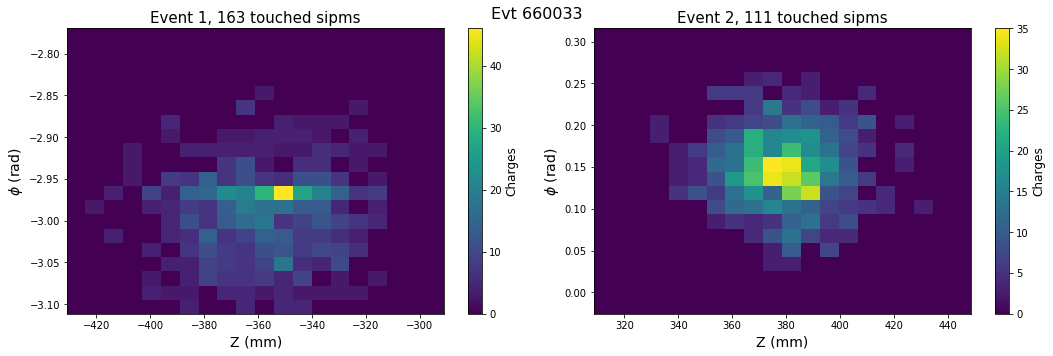

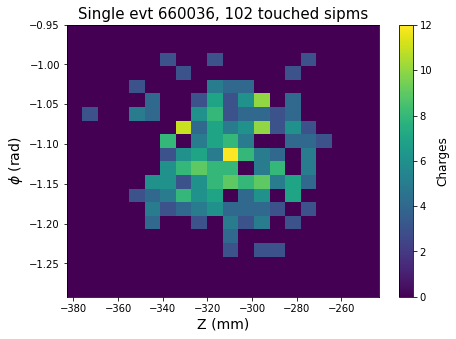

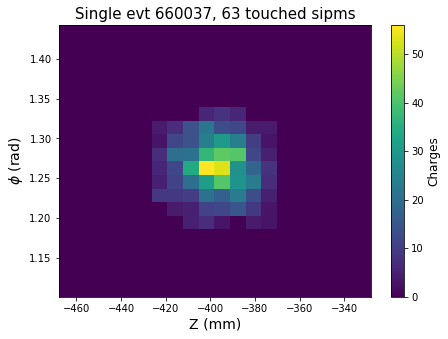

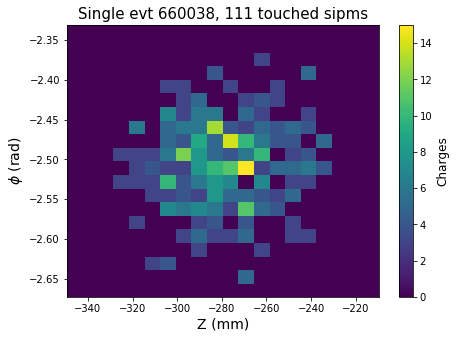

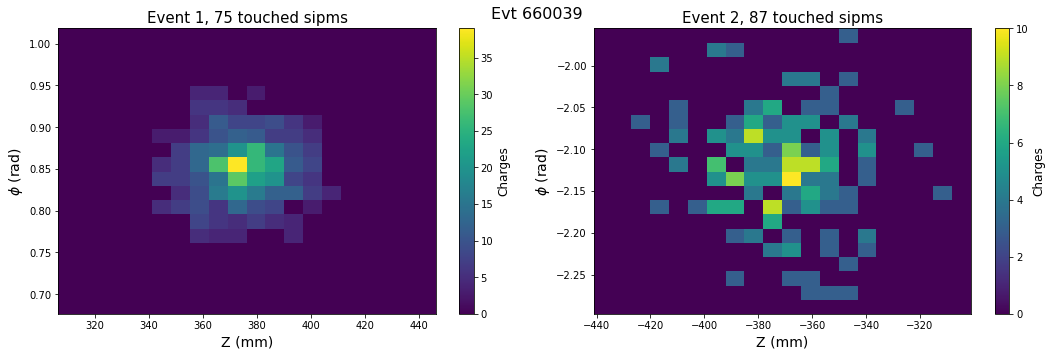

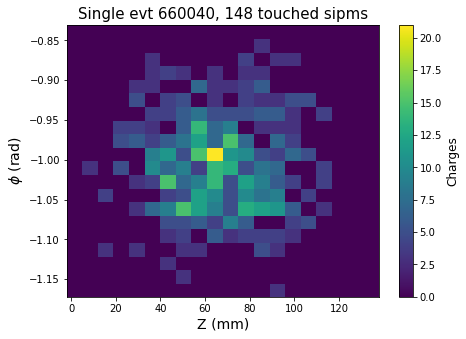

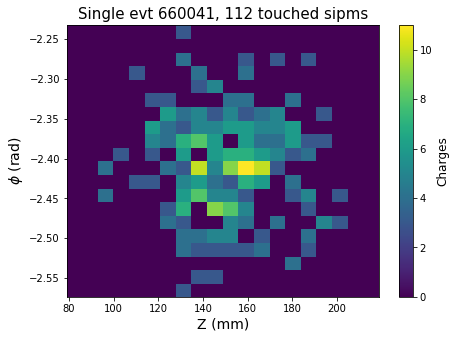

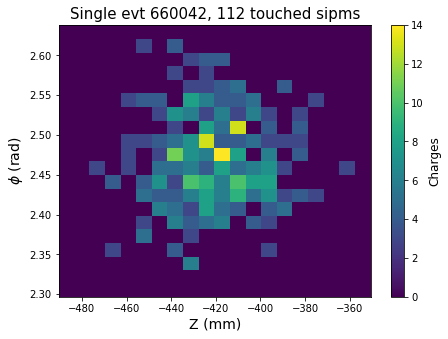

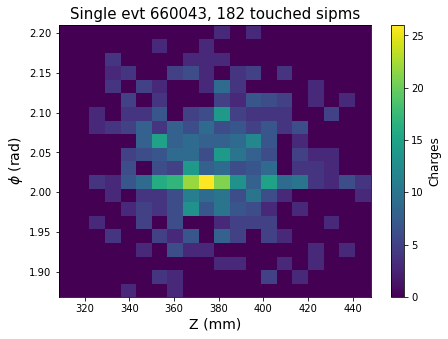

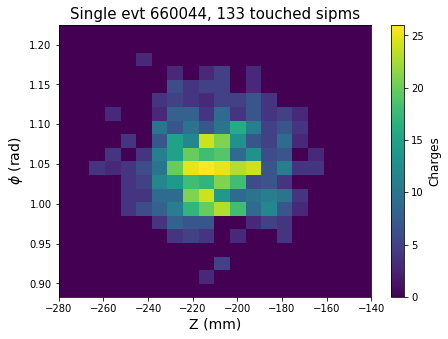

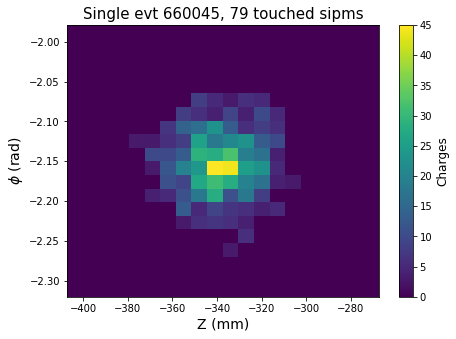

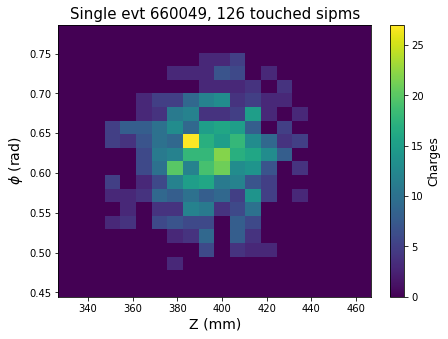

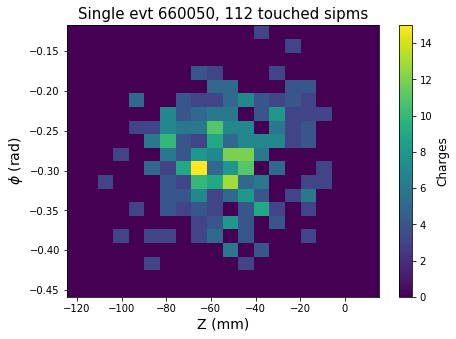

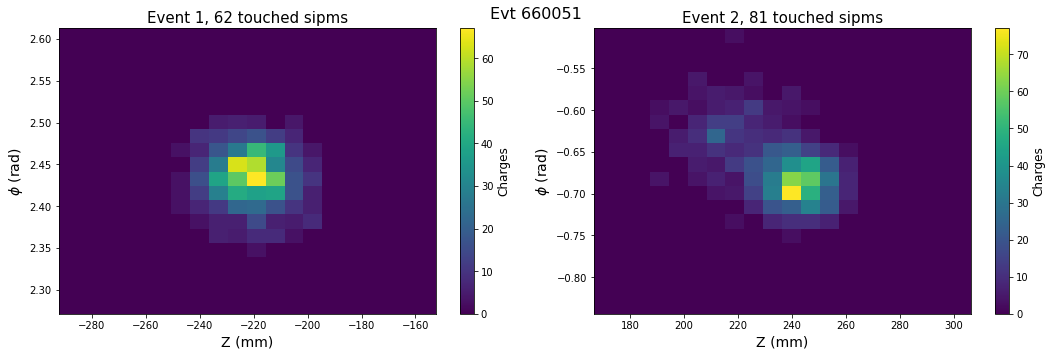

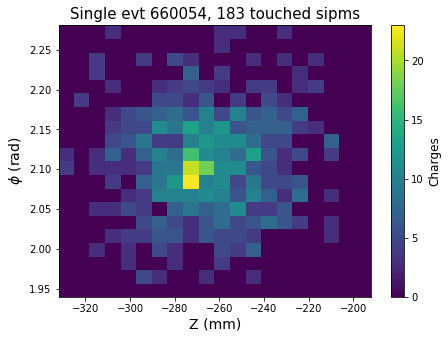

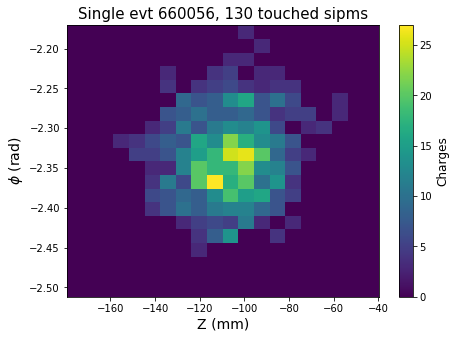

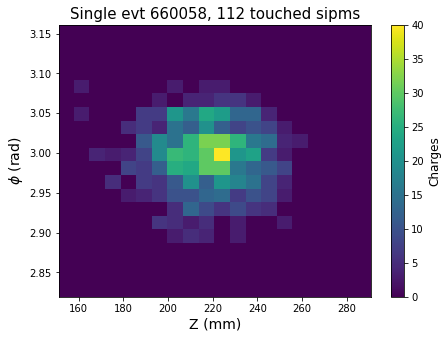

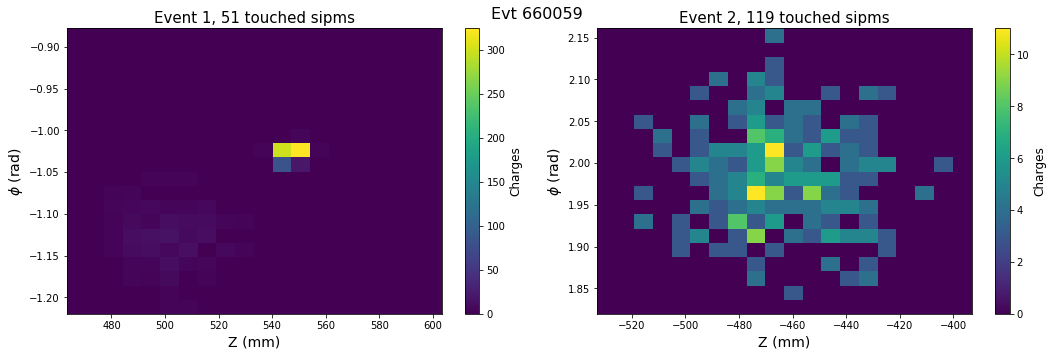

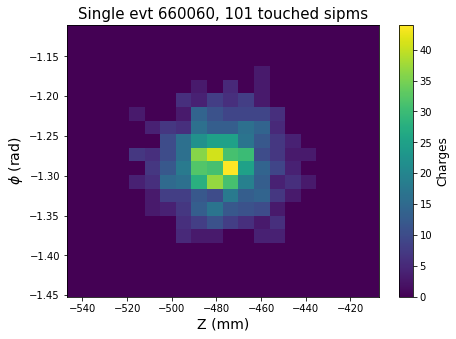

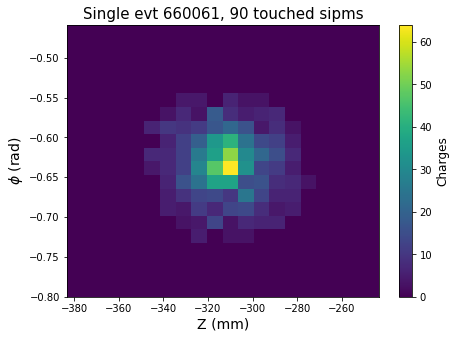

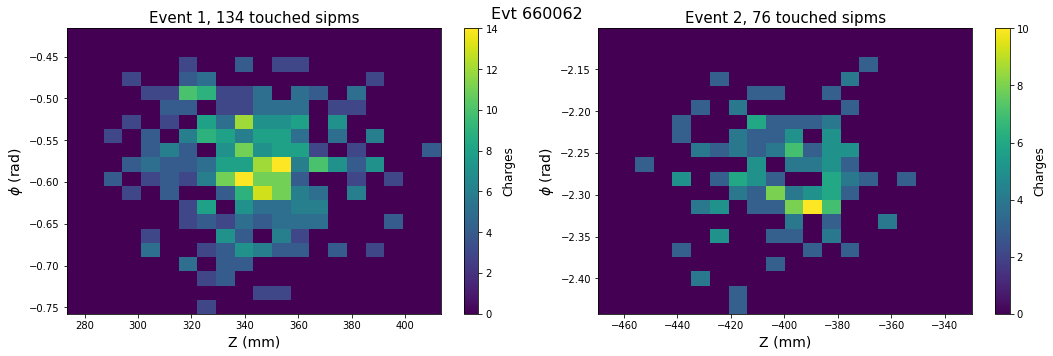

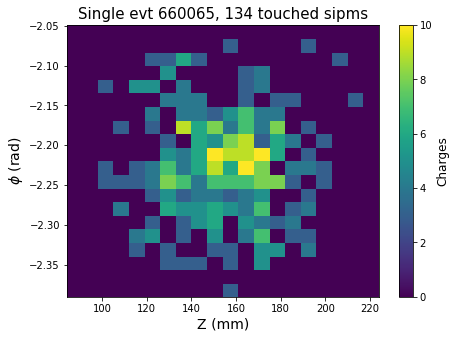

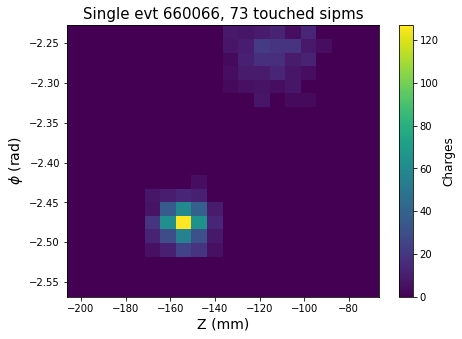

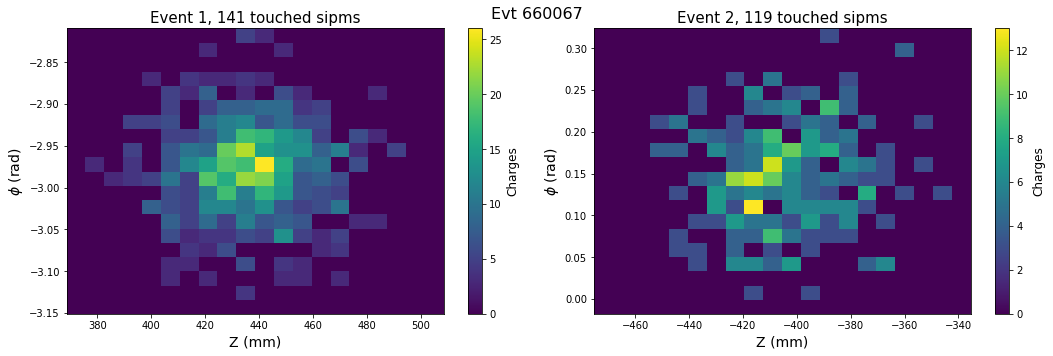

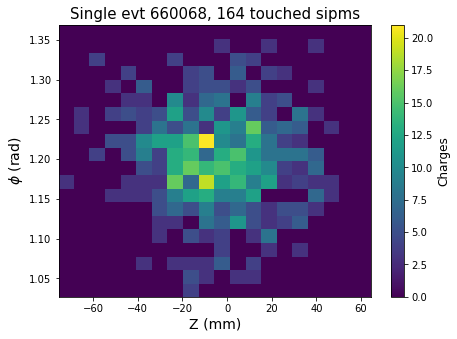

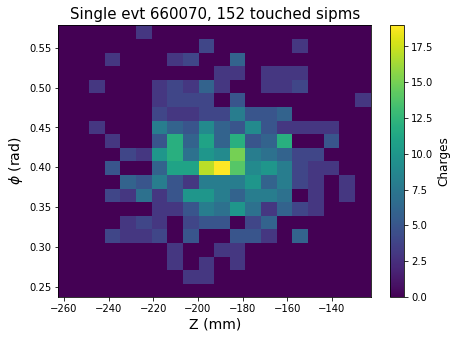

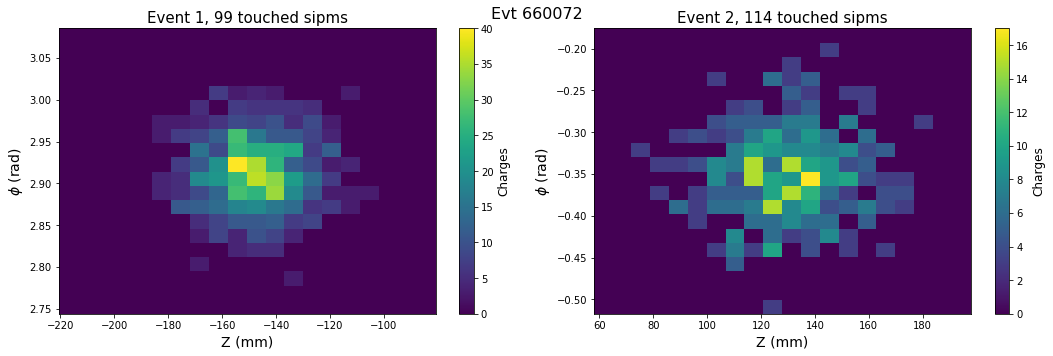

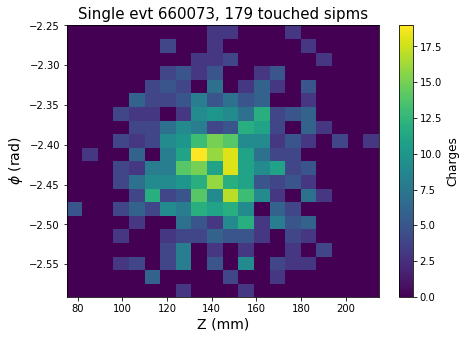

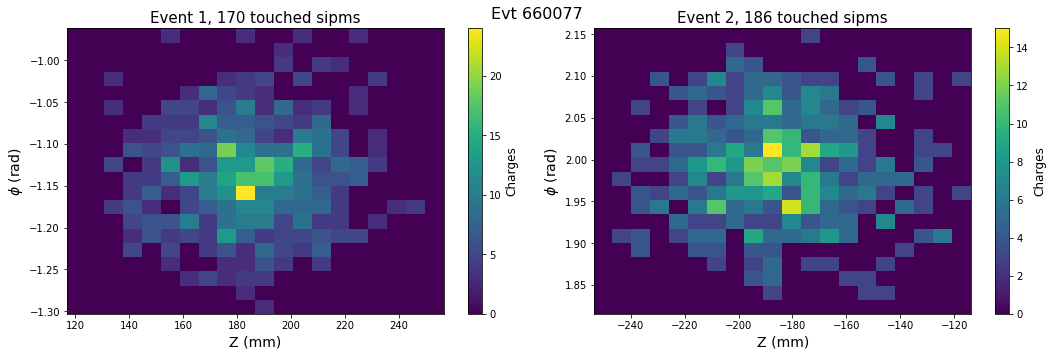

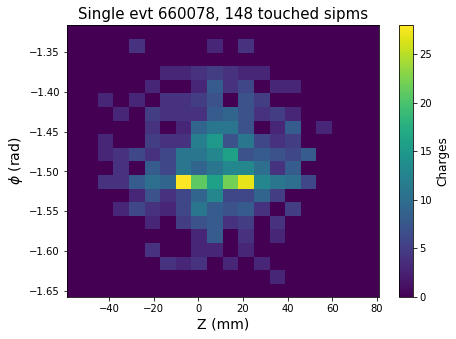

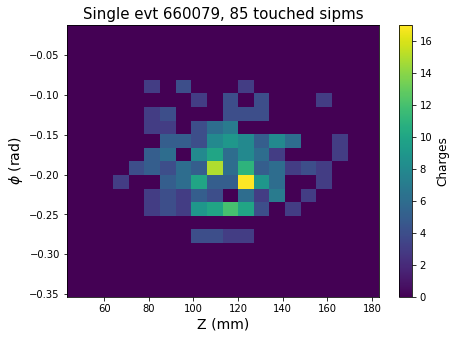

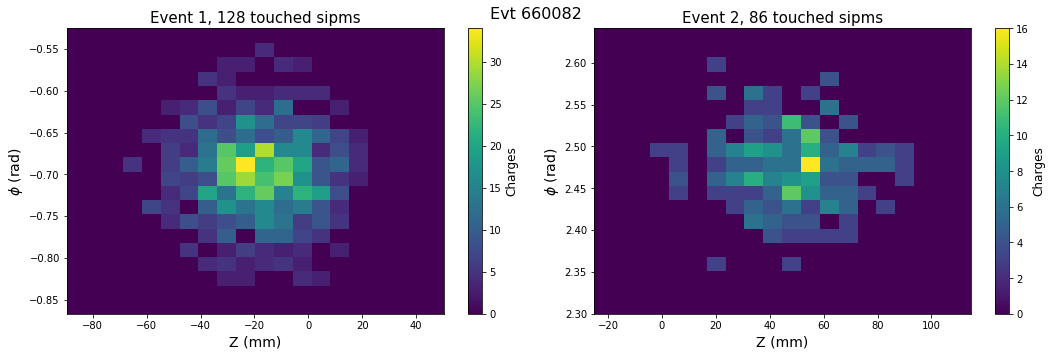

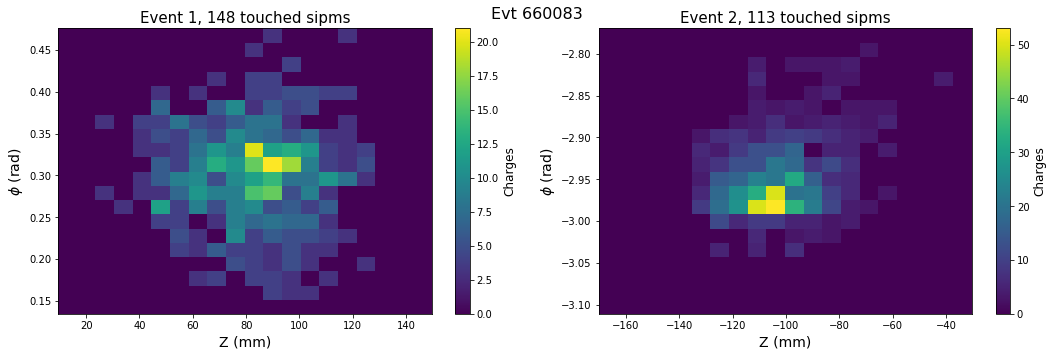

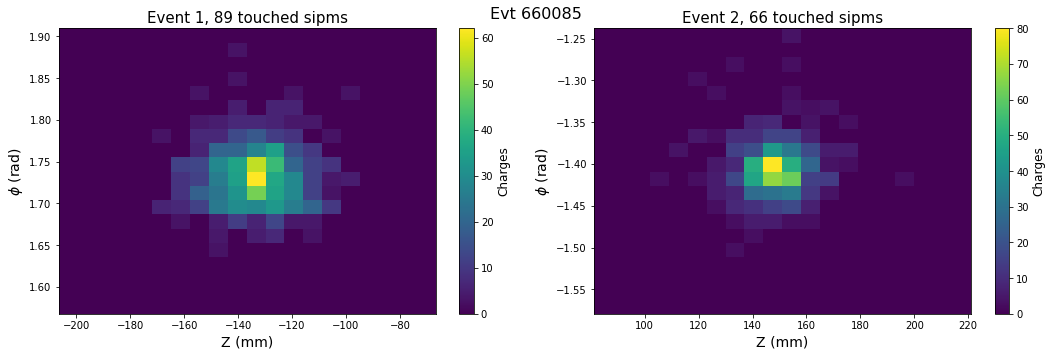

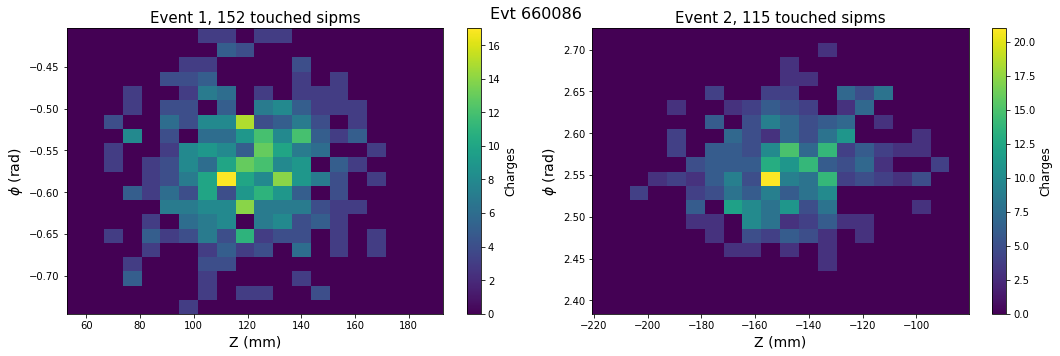

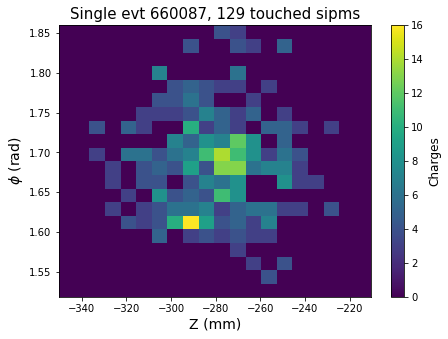

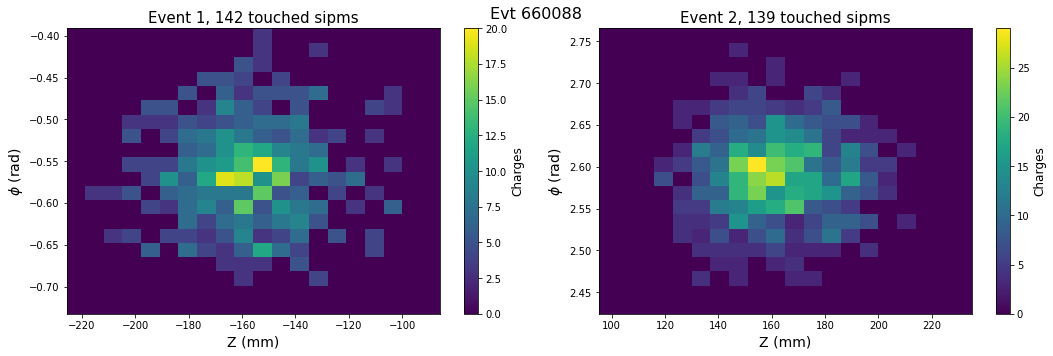

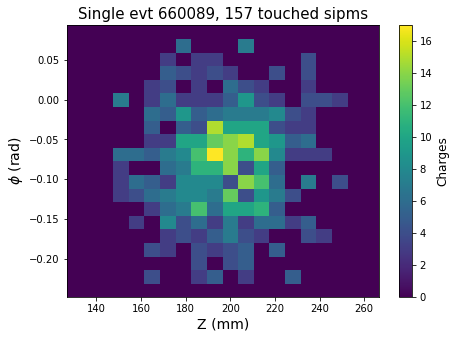

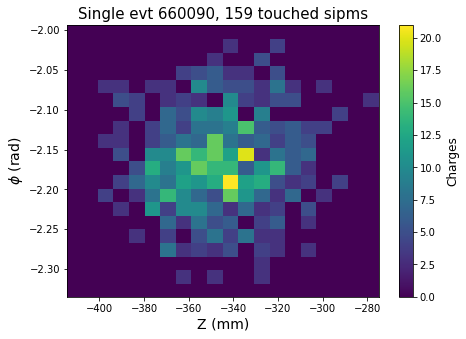

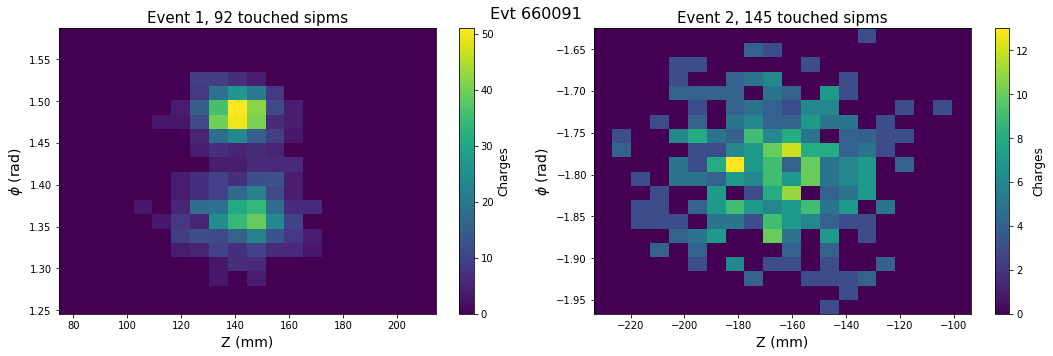

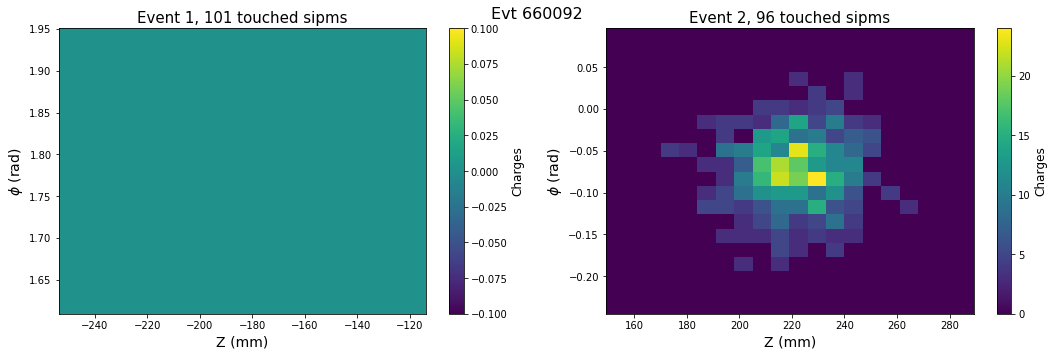

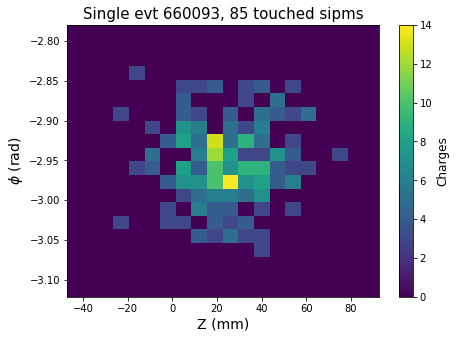

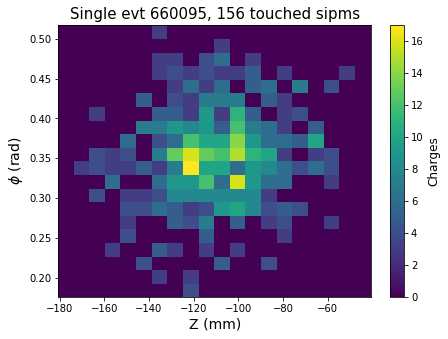

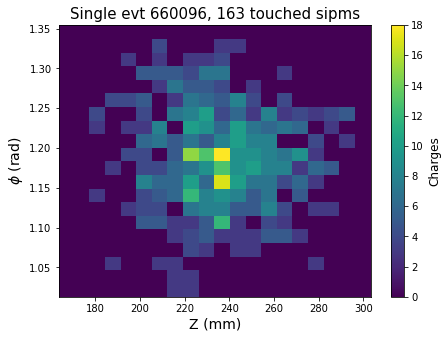

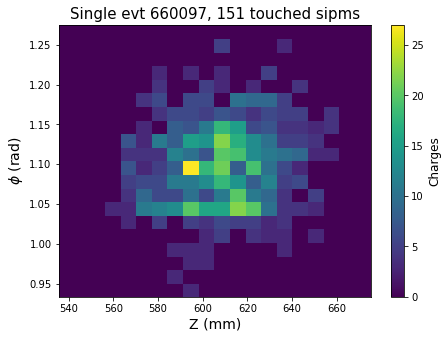

In [93]:
sel_df          = find_SiPMs_over_threshold(sns_response, threshold=2)
images          = []
min_touched_sns = 50
for ev_num, truepos in compton_evts_dict.items():
    #if ev_num == 660024:
    #    break
    waveforms = sel_df[sel_df.event_id == ev_num]
    id1, id2, pos1, pos2, q1, q2 = assign_sipms_to_gammas(waveforms, truepos, DataSiPM_idx)
    if len(id1)>min_touched_sns and len(id2)>min_touched_sns:
        pos1_cyl, range_z1, range_phi1 = needed_info_to_plot(pos1, q1)
        pos2_cyl, range_z2, range_phi2 = needed_info_to_plot(pos2, q2)
        h1, h2 = twoevents_matrix_z_phi(ev_num, pos1_cyl, pos2_cyl, q1, q2, 
                           range_z1, range_z2, range_phi1, range_phi2)
        if len(np.nonzero(h1[0].flatten())[0])>min_touched_sns:
            images.append(h1)
        if len(np.nonzero(h2[0].flatten())[0])>min_touched_sns:
            images.append(h2)
    else:
        if len(pos1)>min_touched_sns:
            pos1_cyl, range_z1, range_phi1 = needed_info_to_plot(pos1, q1)
        elif len(id2)>min_touched_sns:
            pos1_cyl, range_z1, range_phi1 = needed_info_to_plot(pos2, q2)
            q1 = q2
        else:
            continue
        h1 = single_event_matrix_z_phi(ev_num, pos1_cyl, q1, range_z1, range_phi1)
        if len(np.nonzero(h1[0].flatten())[0])>min_touched_sns:
            images.append(h1)

In [80]:
h1

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0., 

### Create noise images using random numbers

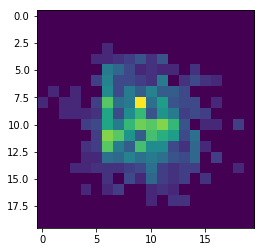

In [96]:
plt.imshow(h1[0])

In [98]:
h1[0].shape

(20, 20)

## Compton new selection:

In the first Compton selection we chose the events with lower energy than photoelectric ones, but this cut can be applied only having into account the energy of the event, however we are interested in events with the same energy but with compton as creator process.

In [22]:
tot_charges2 = []
charge_range = (1050, 1300)
events       = particles.event_id.unique()
for evt in events:
    evt_sns = sns_response[sns_response.event_id == evt]
    evt_sns = rf.find_SiPMs_over_threshold(evt_sns, threshold=0)
    if len(evt_sns) == 0:
        continue

    evt_parts = particles[particles.event_id       == evt]
    evt_hits  = hits[hits.event_id                 == evt]
    evt_tof   = tof_response[tof_response.event_id == evt]

    
    max_sns = evt_sns[evt_sns.charge == evt_sns.charge.max()]
    ## If by chance two sensors have the maximum charge, choose one (arbitrarily)
    if len(max_sns != 1):
        max_sns = max_sns[max_sns.sensor_id == max_sns.sensor_id.min()]
    max_sipm = DataSiPM_idx.loc[max_sns.sensor_id]
    max_pos  = np.array([max_sipm.X.values, max_sipm.Y.values, max_sipm.Z.values]).transpose()[0]
    
    sipms         = DataSiPM_idx.loc[evt_sns.sensor_id]
    sns_ids       = sipms.index.astype('int64').values
    sns_positions = np.array([sipms.X.values, sipms.Y.values, sipms.Z.values]).transpose()
    sns_charges   = evt_sns.charge
    
    sns1, sns2, pos1, pos2, q1, q2 = rf.divide_sipms_in_two_hemispheres(sns_ids, sns_positions, 
                                                                        sns_charges, max_pos)
    
    tot_q1 = sum(q1)
    tot_q2 = sum(q2)

    tot_charges2.append(tot_q1)
    tot_charges2.append(tot_q2)
    sel1 = (tot_q1 > charge_range[0]) & (tot_q1 < charge_range[1])
    sel2 = (tot_q2 > charge_range[0]) & (tot_q2 < charge_range[1])

    if not sel1 or not sel2:
        continue

In [10]:
def charge_selection(sns_response, DataSiPM_idx, charge_range):
    max_sns = sns_response[sns_response.charge == sns_response.charge.max()]
    if len(max_sns != 1):
        max_sns = max_sns[max_sns.sensor_id == max_sns.sensor_id.min()]
    max_sipm = DataSiPM_idx.loc[max_sns.sensor_id]
    max_pos  = np.array([max_sipm.X.values, max_sipm.Y.values, max_sipm.Z.values]).transpose()[0]
    
    sipms         = DataSiPM_idx.loc[sns_response.sensor_id]
    sns_ids       = sipms.index.astype('int64').values
    sns_positions = np.array([sipms.X.values, sipms.Y.values, sipms.Z.values]).transpose()
    sns_charges   = sns_response.charge
    
    sns1, sns2, pos1, pos2, q1, q2 = rf.divide_sipms_in_two_hemispheres(sns_ids, sns_positions, 
                                                                        sns_charges, max_pos)
    tot_q1 = sum(q1)
    tot_q2 = sum(q2)

    sel1 = (tot_q1 > charge_range[0]) & (tot_q1 < charge_range[1])
    sel2 = (tot_q2 > charge_range[0]) & (tot_q2 < charge_range[1])

    if not sel1 or not sel2:
        return None, None, [], [], [], [], [], []
    return sel1, sel2, sns1, sns2, pos1, pos2, q1, q2

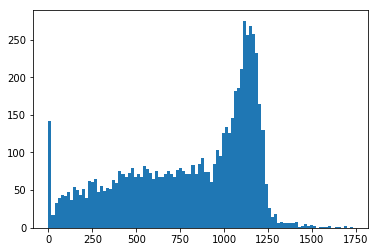

In [21]:
plt.hist(np.array(tot_charges), 100);

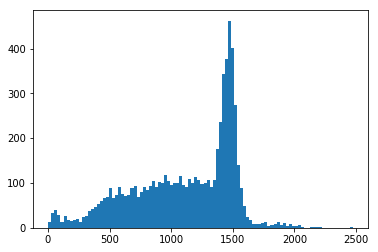

In [23]:
plt.hist(np.array(tot_charges2), 100);

In [9]:
def charge_selection(sns_response, DataSiPM_idx, charge_range):
    max_sns = sns_response[sns_response.charge == sns_response.charge.max()]
    if len(max_sns != 1):
        max_sns = max_sns[max_sns.sensor_id == max_sns.sensor_id.min()]
    max_sipm = DataSiPM_idx.loc[max_sns.sensor_id]
    max_pos  = np.array([max_sipm.X.values, max_sipm.Y.values, max_sipm.Z.values]).transpose()[0]

    sipms         = DataSiPM_idx.loc[sns_response.sensor_id]
    sns_ids       = sipms.index.astype('int64').values
    sns_positions = np.array([sipms.X.values, sipms.Y.values, sipms.Z.values]).transpose()
    sns_charges   = sns_response.charge

    sns1, sns2, pos1, pos2, q1, q2 = rf.divide_sipms_in_two_hemispheres(sns_ids, sns_positions,
                                                                        sns_charges, max_pos)
    tot_q1 = sum(q1)
    tot_q2 = sum(q2)

    sel1 = (tot_q1 > charge_range[0]) & (tot_q1 < charge_range[1])
    sel2 = (tot_q2 > charge_range[0]) & (tot_q2 < charge_range[1])

    if not sel1 and not sel2:
        return None, None, [], [], [], [], [], []
    else:
        return sel1, sel2, sns1, sns2, pos1, pos2, q1, q2

def compton_selection(particles, hits):
    sel_volume = (particles.initial_volume == 'ACTIVE') & (particles.creator_proc == 'compt')
    sel_name   =  particles.name == 'e-'
    sel_all    = particles[sel_volume & sel_name]
    primaries  = particles[particles.primary == True]
    sel_all    = sel_all[sel_all.mother_id.isin(primaries.particle_id.values)]

    ids      = sel_all.particle_id.values
    sel_hits = mcf.find_hits_of_given_particles(ids, hits)
    sel_hits = sel_hits.groupby(['particle_id'])
    true_pos = []
    for _, df in sel_hits:
        hit_positions = np.array([df.x.values, df.y.values, df.z.values]).transpose()
        hit_time      = df.time.values[0]
        cuatrivect    = np.array([np.average(hit_positions, axis=0, weights=df.energy), hit_time])
        true_pos.append(cuatrivect)
    if len(sel_all)==0: 
        return False, False, [], []
    else:
        p1, p2 = [], []
        t1, t2 = [], []
        for p in true_pos:
            if true_pos[0][0].dot(p[0])>0:
                p1.append(p[0])
                t1.append(p[1])
            else:
                p2.append(p[0])
                t2.append(p[1])
        if p1:
            if p2:
                return True, True, np.array([np.average(np.array(p1), axis=0), t1[0]]), np.array([np.average(np.array(p2), axis=0), t2[0]])
            else:
                return True, False, np.array([np.average(np.array(p1), axis=0), t1[0]]), []
        else:
            return False, True, [], np.array([np.average(np.array(p2), axis=0), t2[0]])
                                
        

def needed_info_to_plot(pos, q):
    pos_cyl = rf.from_cartesian_to_cyl(np.array(pos)).transpose()
    barycenter_touched_sns_cyl = np.average(pos_cyl, axis=1, weights=q)
    dist_between_sns_phi = 0.01707387 #rad
    dist_between_sns_z   = 7. #mm (pitch)
    range_phi = (barycenter_touched_sns_cyl[1] - 10*dist_between_sns_phi,
                 barycenter_touched_sns_cyl[1] + 10*dist_between_sns_phi)
    range_z   = (barycenter_touched_sns_cyl[2] - 10*dist_between_sns_z,
                 barycenter_touched_sns_cyl[2] + 10*dist_between_sns_z)
    return pos_cyl, range_z, range_phi

def hist_matrix_z_phi(evt, pos_cyl, q, range_z, range_phi):
    hist = plt.hist2d(pos_cyl[2], pos_cyl[1], bins=(20, 20), range=(range_z, range_phi), weights=q)
    return hist

In [28]:
compt_images    = []
evt_ids         = []
min_touched_sns = 50
threshold       = 2
charge_range    = (1050, 1300)

sens_pos     = pd.read_hdf(filename, 'MC/sensor_positions')

DataSiPM     = sens_pos.rename(columns={"sensor_id": "SensorID","x": "X", "y": "Y", "z": "Z"})
DataSiPM_idx = DataSiPM.set_index('SensorID')

events = particles.event_id.unique()

for evt in events:
    images = []
    ### Select compton events only
    evt_parts = particles   [particles   .event_id == evt]
    evt_hits  = hits        [hits        .event_id == evt]
    evt_sns   = sns_response[sns_response.event_id == evt]

    sel_df = rf.find_SiPMs_over_threshold(evt_sns, threshold=threshold)
    sel1, sel2, sns1, sns2, pos1, pos2, q1, q2 = charge_selection(sel_df, DataSiPM_idx, charge_range)
    if not sel1 and not sel2: continue

    compt1, compt2, true_pos1, true_pos2 = compton_selection(evt_parts, evt_hits)
    #t = compton_selection(evt_parts, evt_hits)
    if not compt1 and not compt2: continue
    if sel1 and sel2 and compt1 and compt2: #to simplify 
        check_pos = np.array([np.average(pos1, weights=q1, axis=0).dot(true_pos1[0]), 
                              np.average(pos1, weights=q1, axis=0).dot(true_pos2[0]),
                              np.average(pos2, weights=q2, axis=0).dot(true_pos1[0]),
                              np.average(pos2, weights=q2, axis=0).dot(true_pos2[0])])
        if len(check_pos[check_pos>0]) != 2:
            continue
        print(evt, true_pos1, true_pos2)

660006 [array([-381.44254,  131.53198,   27.53168], dtype=float32) 1.3490883] [array([ 372.90778 , -126.85636 ,  -23.212929], dtype=float32) 1.312578]
660022 [array([393.92126 , 128.50146 , -44.719498], dtype=float32) 1.3904353] [array([-371.9084  , -121.344795,   42.24007 ], dtype=float32) 1.3125497]
660033 [array([-384.02667,  -55.15875, -364.0745 ], dtype=float32) 1.7756276] [array([395.315   ,  55.572998, 378.7389  ], dtype=float32) 1.8354398]
660051 [array([-313.8636 ,  258.80588, -223.00154], dtype=float32) 1.5657665] [array([ 323.38312, -236.8143 ,  218.03064], dtype=float32) 1.5219665]
660074 [array([-168.20978,  374.63525,  137.37354], dtype=float32) 1.4443786] [array([ 149.47662, -385.72537, -160.00084], dtype=float32) 1.5876354]
660188 [array([ -90.92568, -391.01663,   94.96025], dtype=float32) 1.3782247] [array([ 97.37887, 379.62622, -95.99756], dtype=float32) 1.3556598]
660192 [array([-290.08136, -272.25696, -207.1834 ], dtype=float32) 1.4960381] [array([293.255  , 258.856

KeyboardInterrupt: 

In [102]:
compt_list = []
my_file    = '/Users/carmenromoluque/Desktop/full_body_4cmdepth_compt_images_22_1_2.npz'
d          = np.load(my_file, allow_pickle=True)
for im in d['compt_images']:
    compt_list.append(im)
compt_images = np.array(compt_list)
len(compt_images)

75

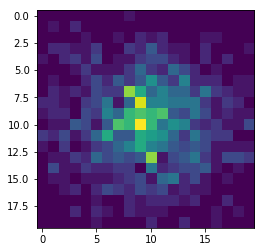

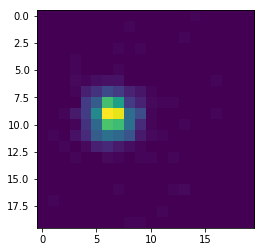

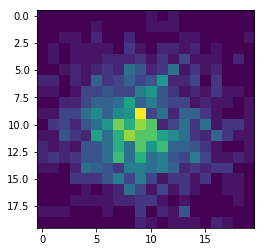

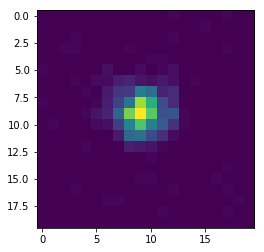

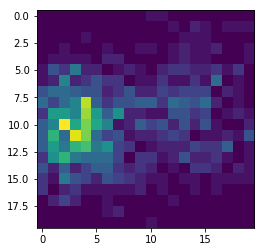

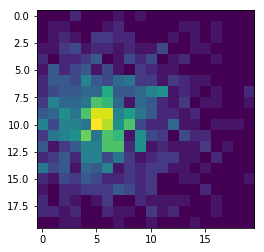

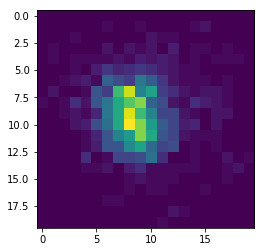

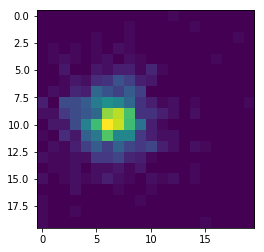

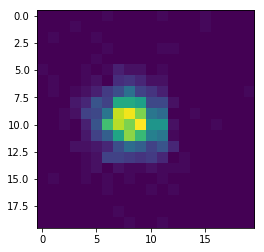

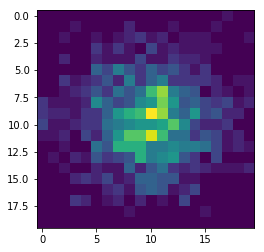

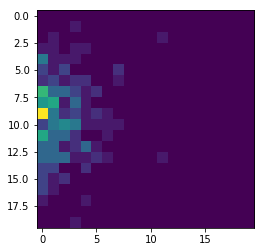

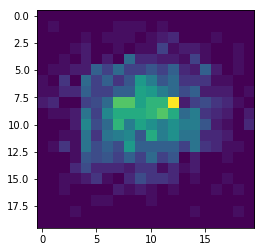

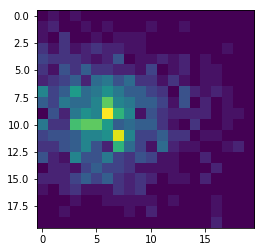

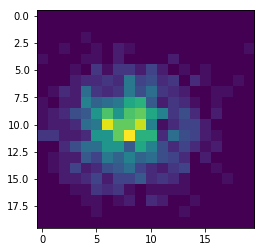

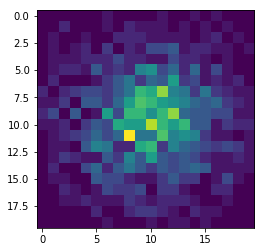

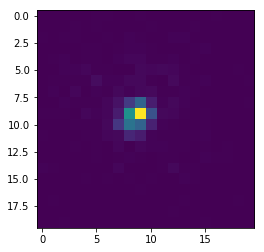

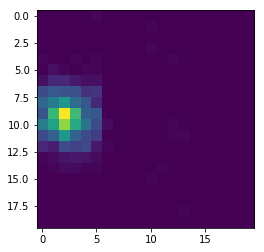

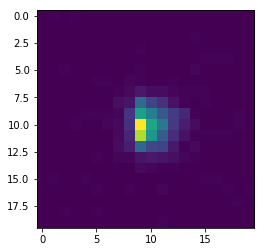

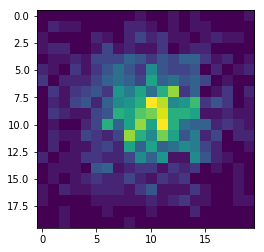

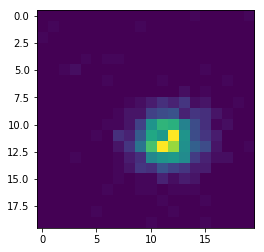

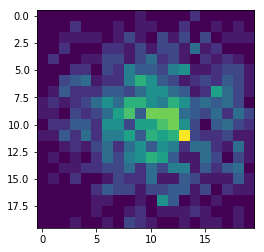

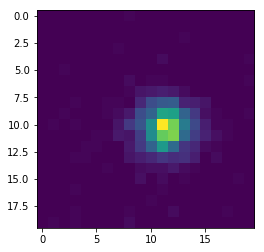

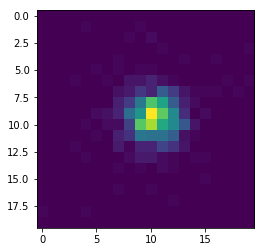

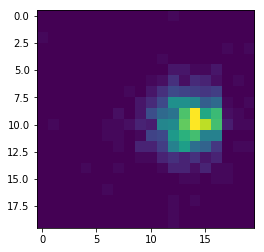

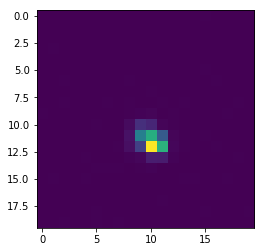

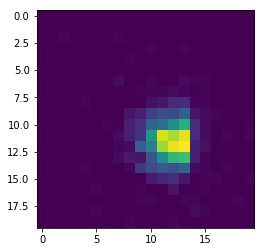

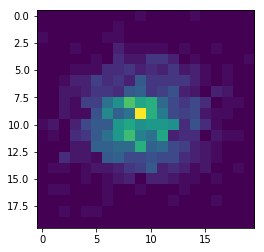

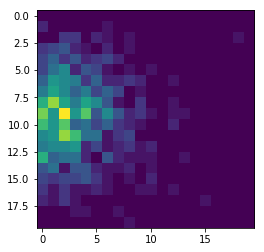

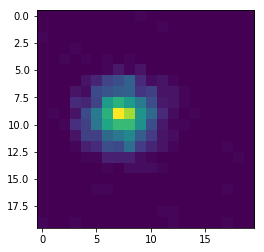

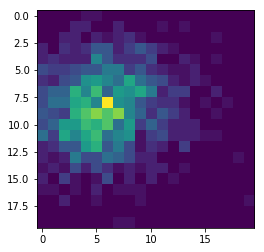

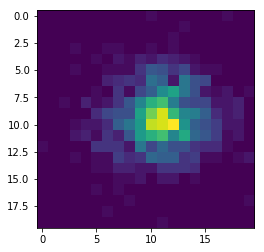

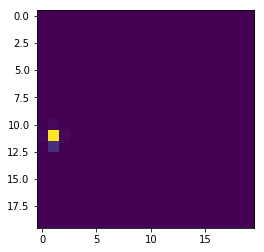

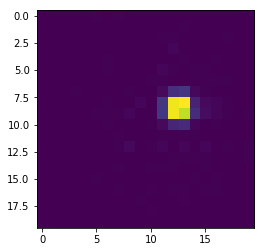

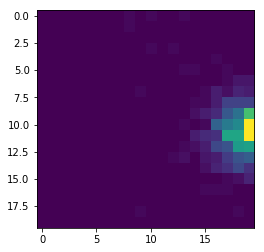

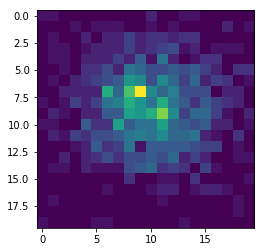

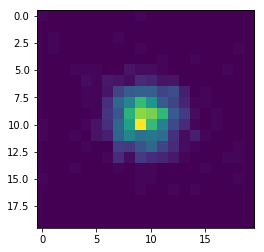

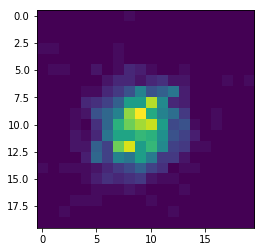

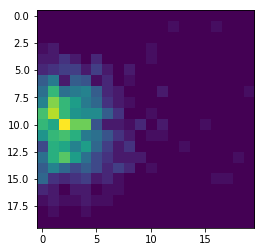

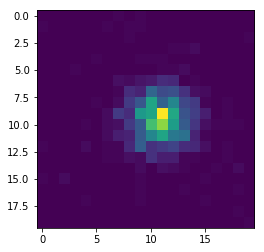

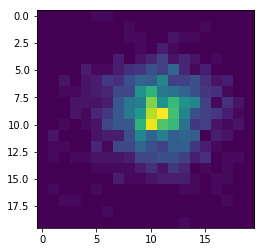

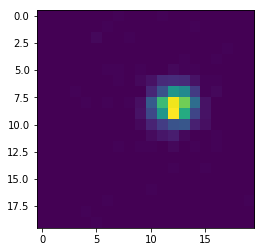

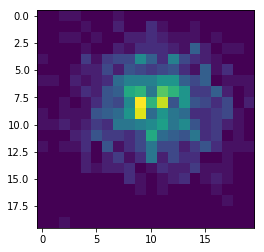

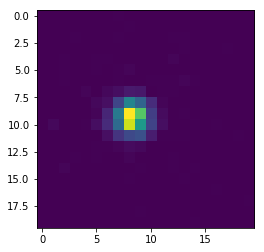

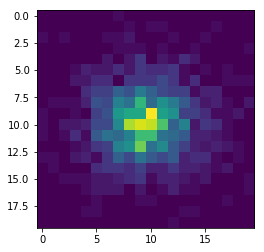

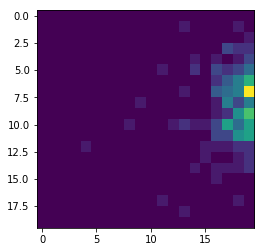

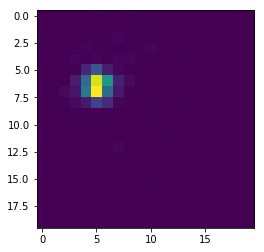

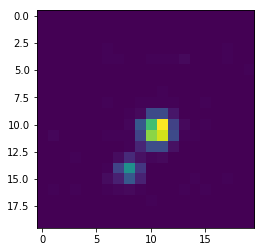

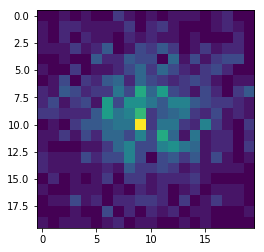

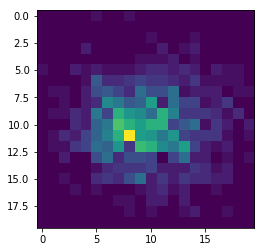

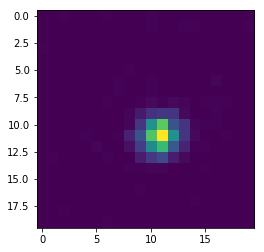

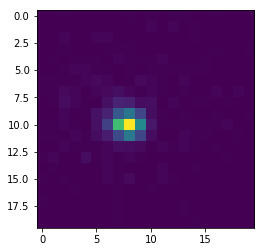

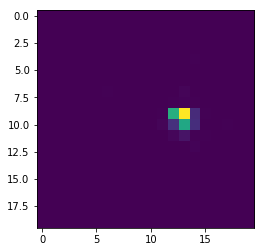

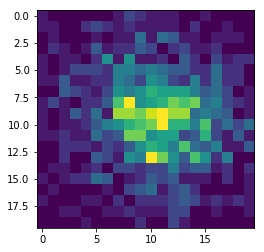

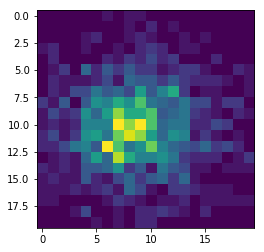

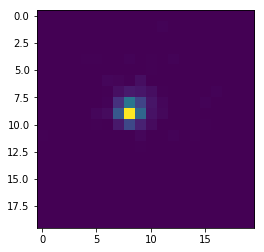

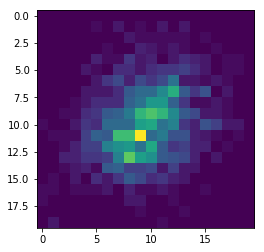

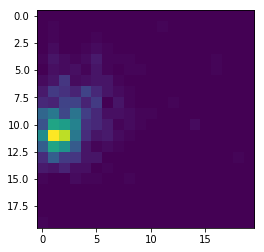

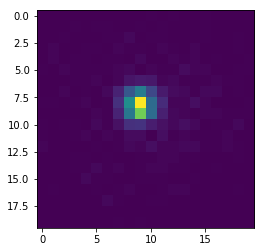

In [118]:
for i in compt_images:
    try:
        plt.imshow(i[0])
        plt.show()
    except IndexError:
        continue

In [37]:
tot_charges2 = []
charge_range = (1050, 1300)
events       = particles.event_id.unique()
for evt in events:
    
    evt_parts = particles   [particles   .event_id == evt]
    evt_hits  = hits        [hits        .event_id == evt]
    evt_sns   = sns_response[sns_response.event_id == evt]

    sel_df = rf.find_SiPMs_over_threshold(evt_sns, threshold=threshold)
    sel1, sel2, sns1, sns2, pos1, pos2, q1, q2 = charge_selection(sel_df, DataSiPM_idx, charge_range)
    if not sel1 and not sel2: continue

    compt1, compt2, true_pos1, d1, true_pos2, d2 = compton_selection2(evt_parts, evt_hits)
    if d1>10 or d2>10:
        print(d1, d2)


3.2254312 30.10682
16.849808 0
14.951577 0.00013131648
38.703262 0
12.114306 0
12.227946 0
32.155125 0
16.534576 0
18.75887 21.976639
15.04279 0
19.942776 0.029208591
10.906948 18.215803
614.0205 0
0.0 14.575318
24.508665 0
37.57103 0
11.708509 0.023799133
41.431 0.02858209
44.02897 1.1273599
16.903408 0
0.039959956 40.23451
9.000855 18.52049
24.350199 0
57.85676 0
0.0036170813 14.262897
11.322074 0
14.902552 0.012014131
10.900506 0
13.421317 0.011021426
12.196122 0.00565212
113.87491 0
0.019439403 10.573181
0.021939846 13.968248
10.473164 0.66220087
0.0005124915 35.133865
15.506415 0
26.735699 0.610546
3.9494631 16.113573
17.641485 0
13.774026 0
27.753016 6.067417
19.102362 0
12.829167 0
0.0005701154 10.083161
22.552498 0
19.270882 0
10.945799 18.086021
11.311375 0.0076491595
14.87317 0
0.0041862386 23.502537
0.003785053 19.29952
0.006509568 15.726902
0.0 12.586665
37.360363 0
49.838703 0
0.0016940692 19.855963
0.0 22.469868
22.72699 0
0.00040943627 45.657997
15.364042 0
28.783041 0.0

In [35]:
def compton_selection2(particles, hits):
    sel_volume = (particles.initial_volume == 'ACTIVE') & (particles.creator_proc == 'compt')
    sel_name   =  particles.name == 'e-'
    sel_all    = particles[sel_volume & sel_name]
    primaries  = particles[particles.primary == True]
    sel_all    = sel_all[sel_all.mother_id.isin(primaries.particle_id.values)]

    ids      = sel_all.particle_id.values
    sel_hits = mcf.find_hits_of_given_particles(ids, hits)
    sel_hits = sel_hits.groupby(['particle_id'])
    true_pos = []
    for _, df in sel_hits:
        hit_positions = np.array([df.x.values, df.y.values, df.z.values]).transpose()
        hit_time      = df.time.values[0]
        cuatrivect    = np.array([np.average(hit_positions, axis=0, weights=df.energy), hit_time])
        true_pos.append(cuatrivect)
    if len(sel_all)==0: 
        return False, False, [], 0, [], 0
    else:
        p1, p2 = [], []
        t1, t2 = [], []
        for p in true_pos:
            if true_pos[0][0].dot(p[0])>0:
                p1.append(p[0])
                t1.append(p[1])
            else:
                p2.append(p[0])
                t2.append(p[1])
        if p1:
            min_t1           = min(t1)
            pos_min_compton1 = np.array([p1[t1.index(min_t1)]])
            dist1            = np.linalg.norm(pos_min_compton1 - np.array([np.average(np.array(p1), axis=0)]))
            if p2:
                min_t2           = min(t2)
                pos_min_compton2 = np.array([p2[t2.index(min_t2)]])
                dist2            = np.linalg.norm(pos_min_compton2 - np.array([np.average(np.array(p2), axis=0)]))
                return (True, True, np.array([np.average(np.array(p1), axis=0), t1[0]]), dist1, 
                        np.array([np.average(np.array(p2), axis=0), t2[0]]), dist2)
            else:
                return True, False, np.array([np.average(np.array(p1), axis=0), t1[0]]), dist1, [], 0
        else:
            min_t2           = min(t2)
            pos_min_compton2 = np.array([p2[t2.index(min_t2)]])
            dist2            = np.linalg.norm(pos_min_compton2 - np.array([np.average(np.array(p2), axis=0)]))
            return False, True, [], 0, np.array([np.average(np.array(p2), axis=0), t2[0]]), dist2


In [18]:
evt_parts = particles[particles.event_id == 660006]
evt_parts[evt_parts.initial_t>0].initial_t.min()

1.3124923

In [16]:
evt_parts[evt_parts.initial_t==2.2322407]

,event_id,particle_id,name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,final_t,initial_volume,final_volume,initial_momentum_x,initial_momentum_y,initial_momentum_z,kin_energy,creator_proc
78,660000,10049,e-,0,1,357.348755,-38.624508,564.491455,2.232241,357.346954,-38.62381,564.493286,2.232261,CRYOSTAT,CRYOSTAT,-0.096504,0.066144,0.216737,0.05626,compt


In [20]:
sel_volume = (evt_parts.initial_volume == 'ACTIVE') & (evt_parts.creator_proc == 'compt')
sel_name   =  evt_parts.name == 'e-'
sel_all    = evt_parts[sel_volume & sel_name]
primaries  = evt_parts[evt_parts.primary == True]
sel_all    = sel_all[sel_all.mother_id.isin(primaries.particle_id.values)]
min_t      = sel_all[sel_all.initial_t>0].initial_t.min()
init_compt = evt_parts[evt_parts.initial_t==min_t]
pos_init_compton = np.array([init_compt.initial_x.values,
                             init_compt.initial_y.values,
                             init_compt.initial_z.values]).transpose()

np.linalg.norm(pos_init_compton-ave_hits)

1.3124923

In [26]:
init_compt = evt_parts[evt_parts.initial_t==1.3124923]
init_compt

,event_id,particle_id,name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,final_t,initial_volume,final_volume,initial_momentum_x,initial_momentum_y,initial_momentum_z,kin_energy,creator_proc
471,660006,29614,e-,0,1,371.117584,-127.97142,-26.792858,1.312492,371.112762,-128.0056,-26.787552,1.314235,ACTIVE,ACTIVE,0.348738,-0.244345,-0.288663,0.214101,compt


In [24]:
pos_init_compton = np.array([init_compt.initial_x.values,
                             init_compt.initial_y.values,
                             init_compt.initial_z.values]).transpose()
pos_init_compton

In [25]:
pos_init_compton

array([[ 371.11758 , -127.97142 ,  -26.792858]], dtype=float32)

In [29]:
ave_hits = np.array([ 372.90778 , -126.85636 ,  -23.212929])

In [30]:
np.linalg.norm(pos_init_compton-ave_hits)

4.155003354702624